## Simulador de la Cuenca de Salgar

El siguiente codigo se encarga de simular la cuenca de salgar a partir de la informacion de radar obtenida por Julian, para el evento de Mayo 20.  

La siguiente celda inicia los paquetes necesarios, 
esta simulación se realiza como un primer ensayo del nuevo paquete WMF, el cual no ha sido probado 

In [1]:
%matplotlib inline
from wmf import wmf 
import numpy as np
import pylab as pl
import pickle
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
from IPython import display

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
def plot_sim_single(Qs,Qo=None,mrain=None,Dates=None,ruta=None,
    figsize=(8,4.5),ids=None,legend=True,vline = None, hline = None,
    ylabel='Caudal $[m^3/seg]$'):
    fig=pl.figure(facecolor='w',edgecolor='w',figsize=figsize)
    ax1=fig.add_subplot(111)
    #Fechas
    if Dates==None:
        if len(Qs.shape)>1:
            ejeX=range(len(Qs[0]))
        else:
            ejeX = range(len(Qs))
    else:
        ejeX=Dates
    #Grafica la lluvia
    if mrain<>None:
        ax1AX=pl.gca()
        ax2=ax1.twinx()
        ax2AX=pl.gca()
        ax2.fill_between(ejeX,0,mrain,alpha=0.4,color='blue',lw=0)
        ax2.set_ylabel('Precipitacion[$mm$]',size=14)
        ax2AX.set_ylim(ax2AX.get_ylim() [::-1])
        ax2.tick_params(labelsize = 16)
    #grafica las hidrografas
    ColorSim=['r','g','k','c','y']
    if len(Qs.shape)>1:
        if ids is None:
            ids = np.arange(1,Qs.shape[0]+1)
        for i,c,d in zip(Qs,ColorSim,ids):
            ax1.plot(ejeX,i,c,lw=3.5,label='Sim '+str(d))    
    else:
        ax1.plot(ejeX,Qs,'r',lw=3.5,label='Sim ')    
    if Qo<>None: ax1.plot(ejeX,Qo,'b',lw=2,label='Observed')
    #Pone una linea vertical 
    y1,y2 = ax1.get_ylim()
    ax1.set_ylim(0,y2)
    if vline<>None:
        ax1.vlines(vline, ax1.get_ylim()[0], ax1.get_ylim()[1], lw =2, color = 'k')
    if hline<>None:
        ax1.hlines(hline, ax1.get_xlim()[0], ax1.get_xlim()[1], lw =2, color = 'b')
    #Pone elementos en la figura
    ax1.set_xlabel('Tiempo [$min$]',size=14)
    ax1.set_ylabel(ylabel,size=14)
    ax1.grid(True)
    ax1.tick_params(labelsize = 16)
    if legend:
        lgn1=ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
            fancybox=True, shadow=True, ncol=4)
    if ruta<>None:
        pl.savefig(ruta, bbox_inches='tight')
    pl.show()

In [2]:
cu = wmf.SimuBasin(0,0,0,0,rute='/media/nicolas/Home/nicolas/03_SALGAR/nc_cuencas/cuencaSalgar_2_12mts.nc')

In [3]:
cu.GetGeo_Cell_Basics()

In [4]:
cu.GetGeo_Parameters(rutaParamASC='/home/nicolas/Dropbox/Public/ParamSalgar.txt')

In [5]:
cu.GetGeo_Ppal_Hipsometric()

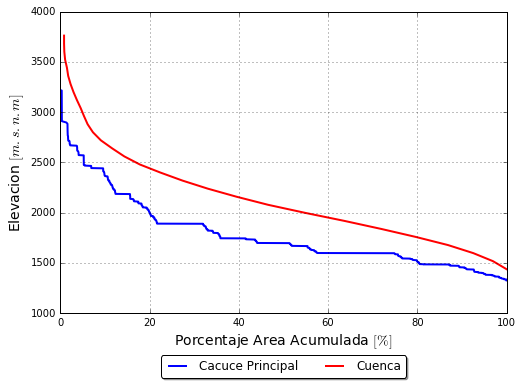

In [13]:
cu.Plot_Hipsometric()

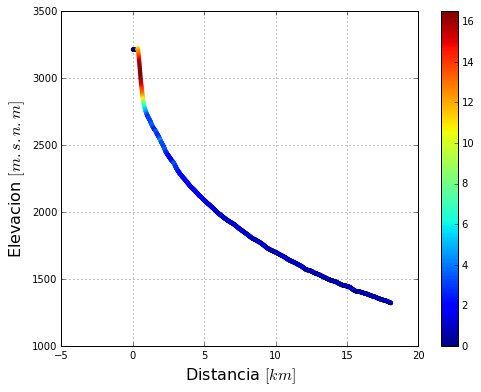

In [14]:
cu.PlotPpalStream()

**Puntos en todos los elementos**: Puntos de control en todas las unidades de la red hidrica 

In [6]:
cu.GetGeo_Cell_Basics()

In [5]:
cauce,nodos,n_nodos = wmf.cu.basin_subbasin_nod(
    cu.structure,
    cu.CellAcum,
    2000,
    cu.ncells)
pos = np.where(nodos<>0)[0]
x,y = wmf.cu.basin_coordxy(cu.structure,cu.ncells)
idsOrd,xy = cu.set_Control(np.vstack([x[pos],y[pos]]),nodos[pos])

**Puntos en los puntos de control**: Puntos solo en los ptos de control

In [6]:
xy,ids = wmf.read_map_points('/media/nicolas/discoGrande/01_SIATA/viejos/SIATA/salgar/vector/ptos_controlQ.shp',
    ListAtr = 'Estacion')

In [7]:
idsOrd, xy = cu.set_Control(xy,[200,201,202])

In [8]:
idsOrd

array([200, 201, 202], dtype=int32)

**Puntos de control de humedad**: Puntos fijos 

In [9]:
xy, ids = wmf.read_map_points('/media/nicolas/discoGrande/01_SIATA/viejos/SIATA/salgar/vector/ptos_controlH_random12.shp',
    ListAtr = 'Estacion')

In [10]:
ids = np.arange(1,xy.shape[1]+1)

In [11]:
idsH, xyH = cu.set_Control(xy, ids, 'H')

## Prepara deslizamientos para la cuenca de salgar 

In [47]:
Fprof = 5
#Valores contantes debido a que no hay mapas 
cu.set_Slides(25,'FrictionAngle')
cu.set_Slides(18,'GammaSoil')
cu.set_Slides(4,'Cohesion')
cu.set_Slides(cu.CellSlope,'Slope')
cu.set_Slides(0.5,'FS')
# Profundidad del suelo 
Z = np.zeros(cu.ncells)
Z[cu.CellSlope<0.25]=0.6
Z[(cu.CellSlope>=0.25)&(cu.CellSlope<0.30)]=1.0
Z[(cu.CellSlope>=0.30)&(cu.CellSlope<0.50)]=0.3
Z[cu.CellSlope>=0.5] = 0.2
#coloca ese parametro 
cu.set_Slides(Z*Fprof,'Zs')
#wmf.models.gammaw = 9.8

In [53]:
Z = np.zeros(cu.ncells)
Z[cu.CellSlope<0.12]=3
Z[(cu.CellSlope>=0.12)&(cu.CellSlope<0.25)]=4
Z[(cu.CellSlope>=0.25)&(cu.CellSlope<0.30)]=6
Z[(cu.CellSlope>=0.30)&(cu.CellSlope<0.50)]=7
Z[cu.CellSlope>=0.5] = 8


In [54]:
cu.Transform_Basin2Map(Z, '/home/nicolas/Dropbox/Public/Zmap.tif')

(array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
       dtype=float32),
 [1021,
  820,
  -76.09495544433594,
  5.924575328826904,
  array(0.00011298, dtype=float32),
  array(0.00011298, dtype=float32),
  array(-9999., dtype=float32)])

In [56]:
A = np.ones(cu.ncells)
for i in [3, 4, 6, 7, 8]:
    print(A[Z == i].sum() / float(cu.ncells))

0.03255517104442049
0.08377772735008793
0.021583366426504793
0.2554518636183128
0.606631871560674


___

Notas sobre lo ensayado:

- El modelo de deslizamientos se hace mucho más suceptible a la profunidad del suelo que a cualquier otro parametro.  Con variaciones de 0.1 a 10 metros varía la cantidad de celdas condicionadas de $0\%$ a
un $80\%$ rápidamente.

- Los parámetros de ángulo de fricción y cohesión no juegan un papel tan relevante. 

- Existe una incoherencia: a medida que el parametro de profundiad del suelo se hace más pequeño la cantidad de celdas que se hacen inestables crece vertiginosamente (no se si esto es un problema en los cálculos o bien en la formulación del modelo).

___
## Prepara Ladera

___
### 3.4  Velocidad en Laderas

La velocidad en laderas puede ser descrita de dos formas:

- Mediante una ecuación no lineal, en este caso se puede asumir que la velocidad depende del almacenamiento y de características regionales en la cuenca asociadas a los surcos, de acuerdo a Vélez (2001) esto se puede escribir:
   * $v_{lad} = \frac{\xi}{n} A ^{(2/3)e_1} S_{0}^{1/2}$  En este caso $\xi$ y $e_1$ van a variar de acuerdo al tipo de surcos que se asuman, en este aspecto diferentes autores proponen diferentes aproximaciones:
      * $\xi$ puede tomar valores de: 0.5, 0.44, 0.38
      * $e_{1}$ puede tomar valores: 0.64, 0.53, 0.315

In [7]:
#Calcula el coeficiente de velocidad en laderas
CoefEsc = (0.5 * cu.CellSlope**(1/2.0)) / 0.120
#Calcula el exponente
Exp = (2/3.0) * 0.64
Original = np.copy(wmf.models.h_coef[0])
#Establece el coef y el exponente del superficial 
cu.set_PhysicVariables('h_coef', CoefEsc, 0)
cu.set_PhysicVariables('h_exp', Exp, 0)
# Coloca superficial y sub-superficial como no lineal 
cu.set_Speed_type([2,2,1])

## Ensayo Prepara Kubota

In [8]:
#Mapa de profundidades:
Z = np.zeros(cu.ncells)
Z[cu.CellSlope<0.25]=0.6
Z[(cu.CellSlope>=0.25)&(cu.CellSlope<0.30)]=1.0
Z[(cu.CellSlope>=0.30)&(cu.CellSlope<0.50)]=0.3
Z[cu.CellSlope>=0.5] = 0.2
#Mapas de almacenamiento maximo capilar y gravitacional
Hu = Z * (0.35 - 0.213) * 1000
Hg = Z * (0.47 - 0.35) * 1000
#Valor de la conductividad 
ks = 4.56 # mm/hr

In [9]:
ksh=(0.00126*cu.CellSlope*(12.7**2.0))/(3*(Hg*0.161/1000.0)**2)
#cu.Plot_basin(ksh)

In [10]:
cu.set_PhysicVariables('h_coef',ksh,1)

___
## Ejecucion de la cuenca 

Se ejecuta la cuenca separando el tipo de evento entre lluvia estratiforme y convectiva 

#### De nuevo calibración 
​
La calibración se compone de 10 parámetros escalares, los cuales son:
- R[1] : Evaporación.
- R[2] : Infiltración.
- R[3] : Percolación.
- R[4] : Pérdidas.
- R[5] : Vel Superficial.
- R[6] : Vel Sub-superficial.
- R[7] : Vel Subterranea.
- R[8] : Vel Cauces.
- R[9] : Alm capilar maximo.
- R[10] : Alm gravitacional maximo.

In [17]:
# Bandera para simulacion de deslizamientos
wmf.models.sim_floods = 0
wmf.models.sim_slides = 0
wmf.models.sl_gullienogullie = 1
wmf.models.sl_fs = 0.7
wmf.models.save_storage = 0
wmf.models.show_speed = 1
wmf.models.separate_fluxes = 1
wmf.models.show_area = 1
wmf.models.save_speed = 0
wmf.models.show_storage = 1

In [18]:
cu.set_Storage(200,3)
cu.set_Storage(wmf.models.max_capilar*0.5, 0)
cu.set_Storage(0.0001,1)
cu.set_Storage(0.0001,2)
cu.set_Storage(0.0001,4)

In [32]:
for c,i in enumerate(Res['Storage']):
    cu.set_Storage(i,c)

NameError: name 'Res' is not defined

In [19]:
#Ejecuta separandopor tipo de lluvia
Npasos = 400
Inicio = 1
#cuSalgar.set_Storage(2,0)
#ruta_lluvia = '/home/nicolas/Dropbox/SIATA/salgar/lluvia/Mayo_18_19_12mts'
ruta_lluvia = '/media/nicolas/discoGrande/03_SALGAR/bin_rain/Mayo_18_19_12mts'
#ruta_lluvia = '/media/nicolas/discoGrande/03_SALGAR/bin_rain/CampoSalgar_20150517_to_20150519_rain'
Calibracion = [0.05, 5, 0.8, 0.0, 1.0, 1.5, 1, 0.996, 2.0, 1.0]
Res = cu.run_shia(Calibracion,ruta_lluvia+'.bin',Npasos, Inicio, kinematicN=4,)
    #ruta_speed='speed_maps2',
    #ruta_storage='Storage_maps2')
Rain = wmf.read_mean_rain(ruta_lluvia+'.hdr',Npasos,Inicio)

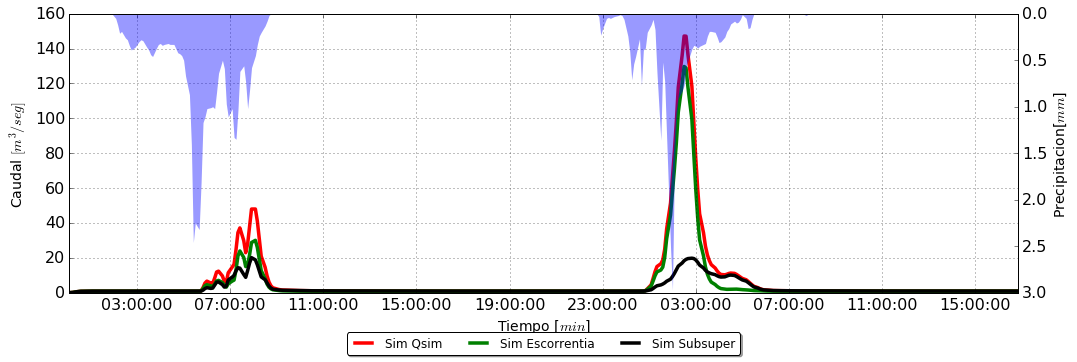

In [20]:
Qsim = Res['Qsim'][0]
Base = Qsim - Res['Fluxes'][0][0] - Res['Fluxes'][0][1]
Runoff = Res['Fluxes'][0][0] + Base
SubSuper = Res['Fluxes'][0][1] + Base

plot_sim_single(np.vstack([Qsim, Runoff, SubSuper]), 
    ids=['Qsim','Escorrentia', 'Subsuper'], Dates = Rain.index.to_pydatetime(),
    mrain = Rain.values,
    #ruta = 'Figuras-6-Enero-2016/Simulaciones/Sim_Qsim_Res.png',
    figsize=(17,5),)

In [35]:
100* (Res['Balance'].sum() /(Rain.values.sum() * cu.ncells))

0.40489378246420843

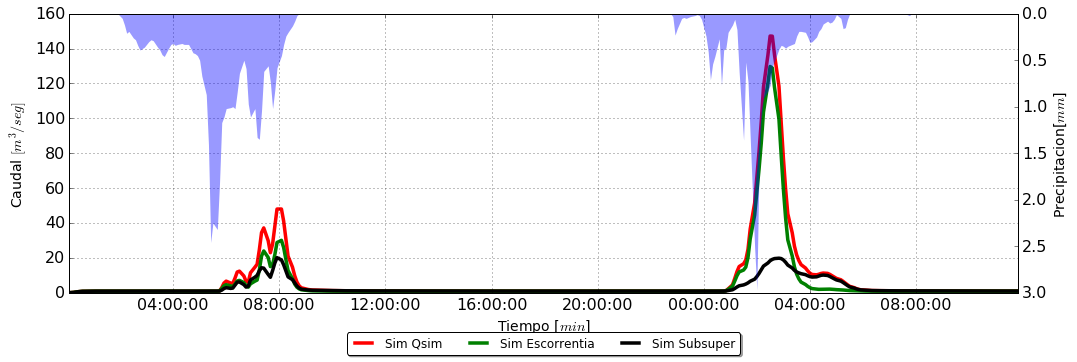

In [62]:
Qsim = Res['Qsim'][0]
Base = Qsim - Res['Fluxes'][0][0] - Res['Fluxes'][0][1]
Runoff = Res['Fluxes'][0][0] + Base
SubSuper = Res['Fluxes'][0][1] + Base

plot_sim_single(np.vstack([Qsim, Runoff, SubSuper]), 
    ids=['Qsim','Escorrentia', 'Subsuper'], Dates = Rain.index.to_pydatetime(),
    mrain = Rain.values,
    #ruta = 'Figuras-6-Enero-2016/Simulaciones/Sim_Qsim_Res.png',
    figsize=(17,5),)

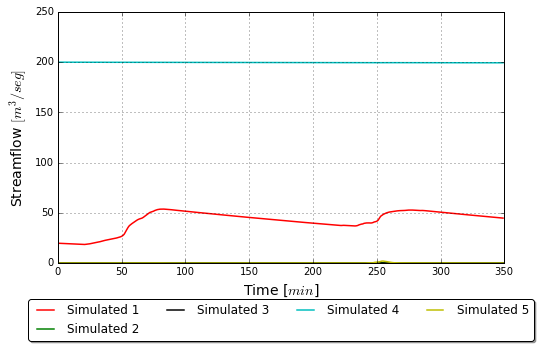

In [64]:
wmf.plot_sim_single(Res['Mean_Storage'])

In [26]:
f = open('Animacion/SeriesAnim2.bin', 'w')
pickle.dump(Qsim, f)
pickle.dump(Runoff, f)
pickle.dump(SubSuper, f)
pickle.dump(Rain, f)
f.close()

**Descripcion**: Hidrógrafa a la salida de la cuenca mostrando la separación de los flujos de escorrentía superficial y sub-superficial, en este caso el modelo es casi en su totalidad no-lineal. Se observan caudales máximos de hasta 140$m^3/seg$, se estima que el caudal debió superar los 100m3/seg para ocasionar el desastre.

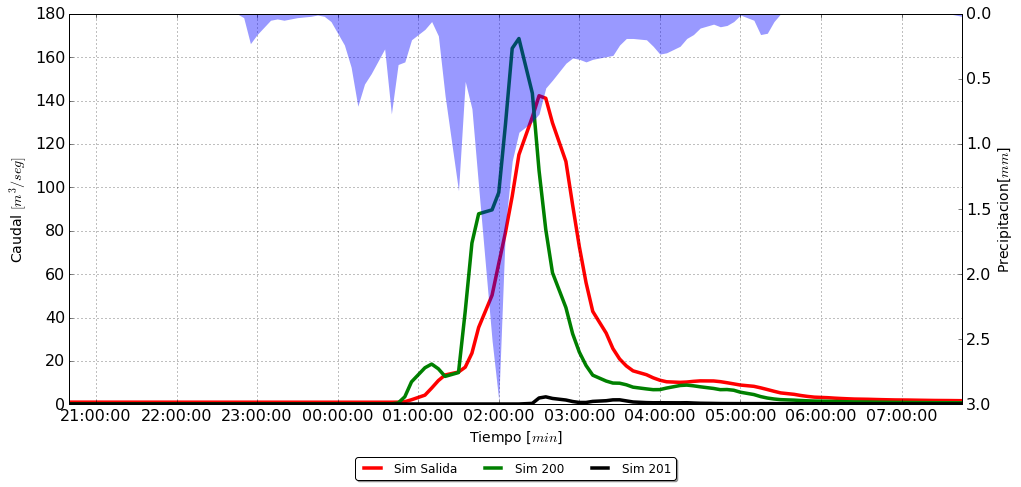

In [166]:
plot_sim_single(np.vstack([Res['Qsim'][0][200:310],Res['Qsim'][1][200:310],Res['Qsim'][2][200:310]]), 
    ids=['Salida','200','201'], Dates = Rain.index.to_pydatetime()[200:310],
    mrain = Rain.values[200:310],
    #ruta = 'Figuras-6-Enero-2016/Simulaciones/Sim_Qsim_Res.png',
    figsize=(16,7))

**Arriba**: Se observa como entre el punto de control 200 y la salia la honda viaja y se disipa en el viaje.

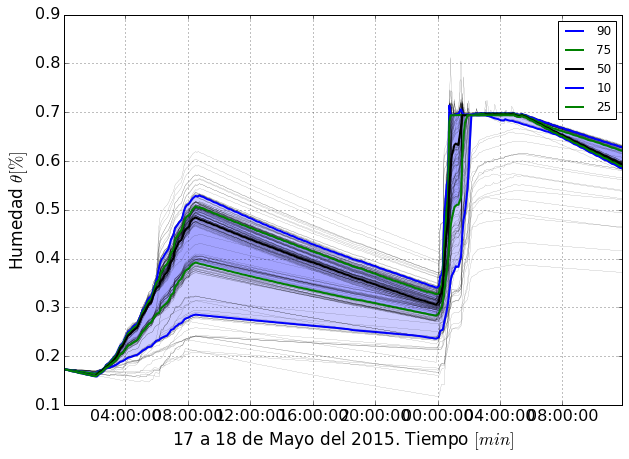

In [65]:
Hu = np.copy(wmf.models.max_capilar)*2.0
Hg = np.copy(wmf.models.max_gravita)

pos = np.where(wmf.models.control_h<>0)[1]
HumedadRel=[]
for i,p in zip(Res['Humedad'],pos):
    HumedadRel.append(i/(Hu[0][p]+Hg[0][p]))
HumedadRel=np.array(HumedadRel)
HumPer={}
for i in [90,75,50,25,10]:
    HumPer.update({str(i):np.percentile(HumedadRel,i,axis=0)})

colors = ['b','g','k','b','g']
fig = pl.figure(edgecolor='w',facecolor='w',figsize=(10,7))
ax = fig.add_subplot(111)
for i in HumedadRel:
    ax.plot(Rain.index.to_pydatetime(),i,'k',lw=0.1)
for i,c in zip(HumPer.keys(),colors):
    ax.plot(Rain.index.to_pydatetime(),HumPer[i],c=c,lw=2,label=i)
ax.fill_between(Rain.index.to_pydatetime(),HumPer['10'],HumPer['90'],alpha=0.2)
ax.fill_between(Rain.index.to_pydatetime(),HumPer['25'],HumPer['75'],alpha=0.2)
ax.tick_params(labelsize = 16)
ax.grid(True)
ax.legend(loc=0)
ax.set_xlabel('17 a 18 de Mayo del 2015. Tiempo $[min]$',size=17)
ax.set_ylabel('Humedad $\\theta [\\%]$',size=17)
#pl.savefig('imagenes12/Soil_Moisture_Percentiles_18_10:55_1:50.png')

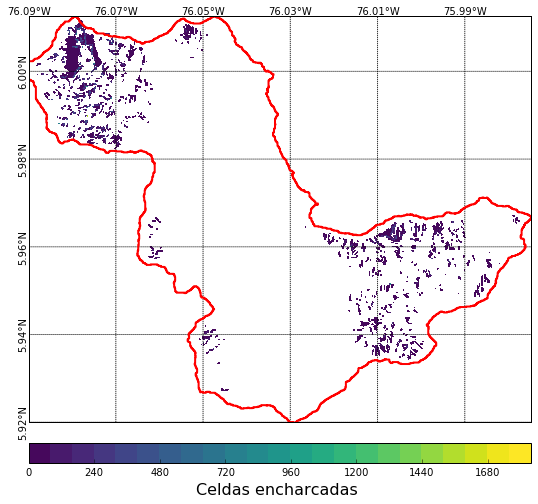

In [167]:
cu.Plot_basin(wmf.models.retorned, ZeroAsNaN='si', colorTable=pl.get_cmap('viridis'), 
    colorbarLabel='Celdas encharcadas ')

**arriba**: Celdas que se han encharcado es decir, en estas celdas Hg se ha alcanzado en algún punto y se ha retornado el flujo a la superficie.

In [183]:
StoSum = np.zeros(cu.ncells)
for i in range(220,300):
    v,r = wmf.models.read_float_basin_ncol('Storage_maps.StObin',i,cu.ncells,5)
    StoSum += v[2]+v[0]

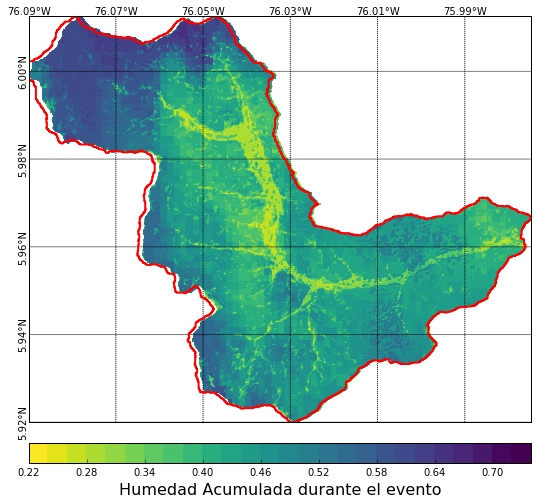

In [194]:
cu.Plot_basin(StoSum/(Hu*80+Hg*80), colorTable=pl.get_cmap('viridis_r'), 
    colorbarLabel='Humedad Acumulada durante el evento')

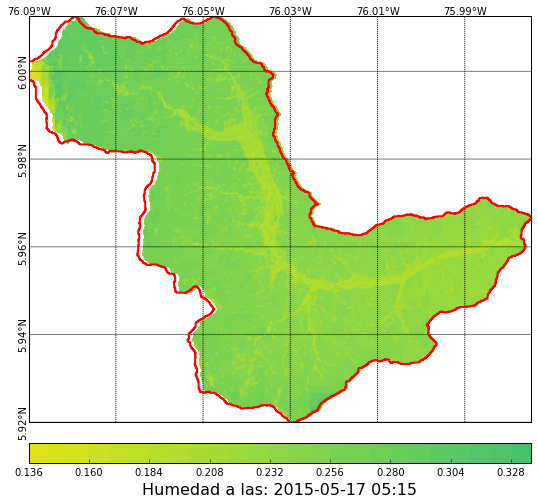

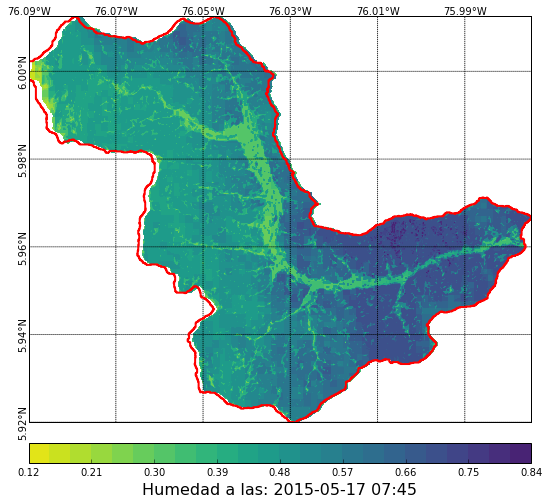

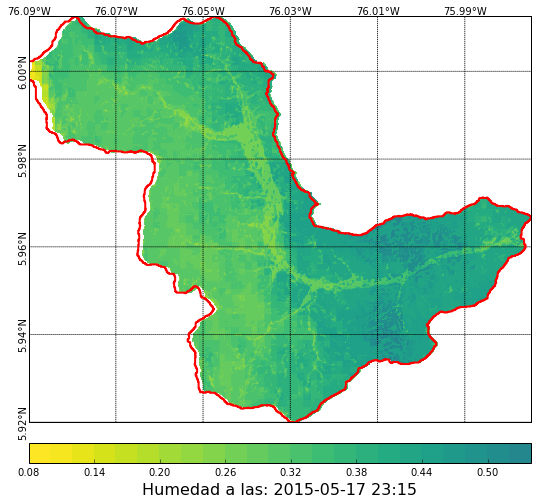

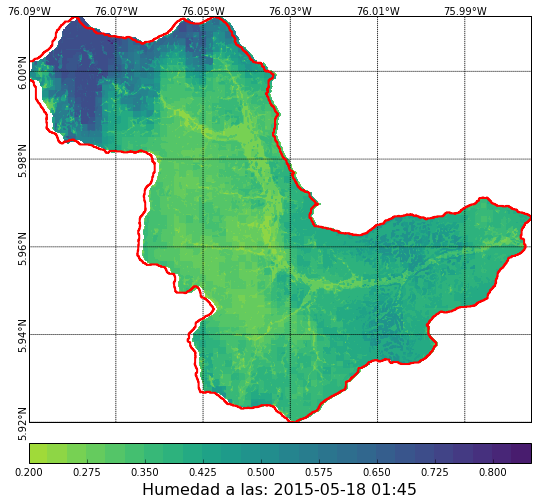

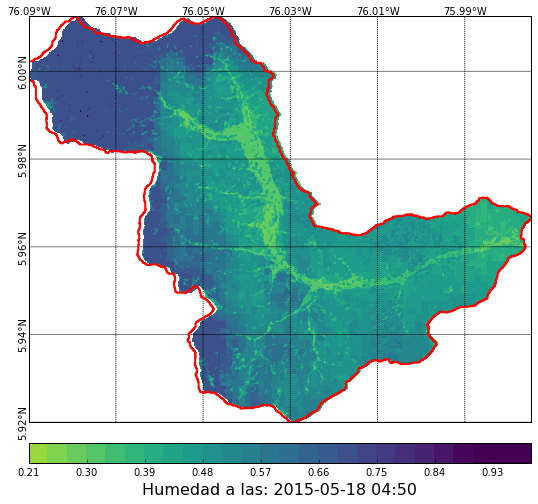

In [225]:
#Evento en pos 50
v,r = wmf.models.read_float_basin_ncol('Storage_maps.StObin',50,cu.ncells,5)
cu.Plot_basin((v[0]+v[2])/(Hu+Hg), colorTable=pl.get_cmap('viridis_r'), 
    colorbarLabel='Humedad a las: '+ Rain.index.to_pydatetime()[50].strftime('%Y-%m-%d %H:%M'),
    colorbar = True,
    vmin = 0.1, vmax = 0.9,)

v,r = wmf.models.read_float_basin_ncol('Storage_maps.StObin',75,cu.ncells,5)
cu.Plot_basin((v[0]+v[2])/(Hu+Hg), colorTable=pl.get_cmap('viridis_r'), 
    colorbarLabel='Humedad a las: '+ Rain.index.to_pydatetime()[75].strftime('%Y-%m-%d %H:%M'),
    colorbar = True,
    vmin = 0.1, vmax = 0.9,)

v,r = wmf.models.read_float_basin_ncol('Storage_maps.StObin',220,cu.ncells,5)
cu.Plot_basin((v[0]+v[2])/(Hu+Hg), colorTable=pl.get_cmap('viridis_r'), 
    colorbarLabel='Humedad a las: '+ Rain.index.to_pydatetime()[225].strftime('%Y-%m-%d %H:%M'),
    colorbar = True,
    vmin = 0.1, vmax = 0.9)

v,r = wmf.models.read_float_basin_ncol('Storage_maps.StObin',245,cu.ncells,5)
cu.Plot_basin((v[0]+v[2])/(Hu+Hg), colorTable=pl.get_cmap('viridis_r'), 
    colorbarLabel='Humedad a las: '+ Rain.index.to_pydatetime()[250].strftime('%Y-%m-%d %H:%M'),
    colorbar = True,
    vmin = 0.1, vmax = 0.9)

v,r = wmf.models.read_float_basin_ncol('Storage_maps.StObin',280,cu.ncells,5)
cu.Plot_basin((v[0]+v[2])/(Hu+Hg), colorTable=pl.get_cmap('viridis_r'), 
    colorbarLabel='Humedad a las: '+ Rain.index.to_pydatetime()[280].strftime('%Y-%m-%d %H:%M'),
    colorbar = True,
    vmin = 0.1, vmax = 0.9)

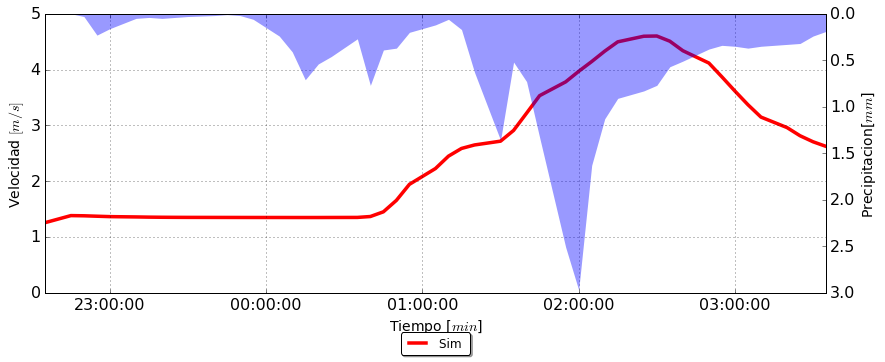

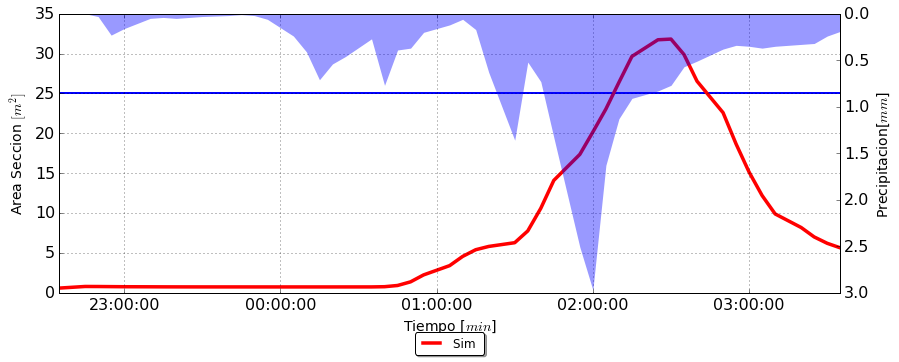

In [48]:
plot_sim_single(Res['Speed'][0]/180, ylabel='Velocidad $[m/s]$', 
    figsize=(14,5), mrain = Rain.values, Dates = Rain.index.to_pydatetime())
plot_sim_single(Res['Sec_Area'][0]*180, ylabel='Area Seccion $[m^2]$', 
    figsize=(14,5), hline = 25,mrain = Rain.values, Dates = Rain.index.to_pydatetime())

**arriba**: Velocidad y areas simuladas. se estima un área máxima de 23m2, en el modelo se tienen areas de hasta 33m2, es decir 10m2 de más de agua.

In [240]:
Area = Res['Sec_Area'][0]*180
pos = np.where(Area>22.5)[0]

In [242]:
FechasInundacion = [Rain.index.to_pydatetime()[i] for i in pos]
for i in FechasInundacion:
    print i.strftime('%H:%M')

02:10
02:15
02:25
02:30
02:35
02:40
02:50


## Deslizamientos paso a paso 

Se va a evaluar para cada paso como opera este modelo de deslizamientos, esto con la finalidad de encontrar donde ocurren errores al interior del modelo 

In [17]:
#Banderas del modelo para no guardar mas y simular deslizamientos 
wmf.models.save_storage = 0
wmf.models.sim_slides = 1
wmf.models.sl_gullienogullie = 0
wmf.models.sl_fs = 0.3

In [14]:
#Cargado de condiciones antecedentes de simulacion
cu.set_Storage('/media/nicolas/Home/nicolas/03_SALGAR/bin_sto/Salgar_Storage.bin.StObin', 200)
#cu.set_Storage('Storage_maps.StOhdr',200)

In [18]:
Npasos = 40
Inicio = 230
ruta_lluvia = '/media/nicolas/Home/nicolas/03_SALGAR/bin_rain/Mayo_18_19_12mts'
#ruta_lluvia = '/media/nicolas/discoGrande/03_SALGAR/bin_rain/Mayo_18_19_12mts'
Calibracion = [0.1, 2.7, 0.8, 0.0, 1.0, 1.5, 0.01, 0.996, 1.0, 1.0]
Calibracion = [0.05, 5, 0.8, 0.0, 1.0, 1.5, 1, 0.996, 2.0, 1.0]
Res = cu.run_shia(Calibracion,ruta_lluvia+'.bin',Npasos,Inicio)
S = wmf.read_mean_rain(ruta_lluvia+'.hdr',Npasos,Inicio)

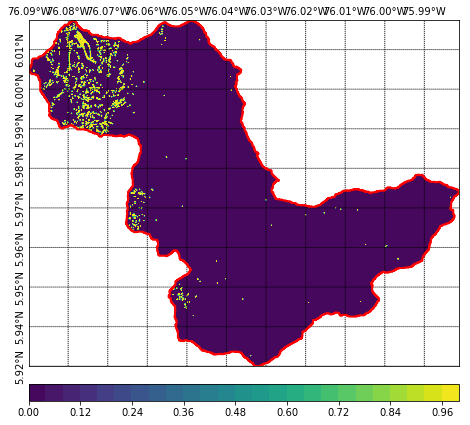

(<mpl_toolkits.basemap.Basemap at 0x7f75fc53b050>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f75fcb09d90>)

In [21]:
cu.Plot_basin(Res[0]['Slides_Map'])

In [33]:
Slides = Res[0]['Slides_Map'][0,:]

In [45]:
S = []
O = []
for i in range(1,6):
    S.append(Slides[cu.CellHorton_Hill == i].sum()/float(Slides.sum()))
    O.append(Desliz[cu.CellHorton_Hill == i].sum()/float(Desliz.sum()))

In [46]:
O

[0.7175242893127024, 0.2601655271680461, 0.022310183519251528, 0.0, 0.0]

In [40]:
64+26+5+3.6+0.005

98.60499999999999

In [25]:
Res[0].keys()

['Slides_Acum',
 'Humedad_t2',
 'Humedad_t1',
 'Storage',
 'Slides_NCell_Serie',
 'Rain_hietogram',
 'Qsim',
 'Slides_Map',
 'Humedad',
 'Balance',
 'Rain_Acum']

In [18]:
plot_sim_single(Res['Slides_NCell_Serie'], mrain=S.values, ids = 'N pixels', 
    ylabel = 'Numero Celdas que Deslizan',
    figsize = (16,6))

TypeError: tuple indices must be integers, not str

**arriba**: Cantidad de celdas que deslizan en el modelo de estabilidad de taludes. Este número varía en función de la cantidad de precipitación en la zona alta de la cuenca 

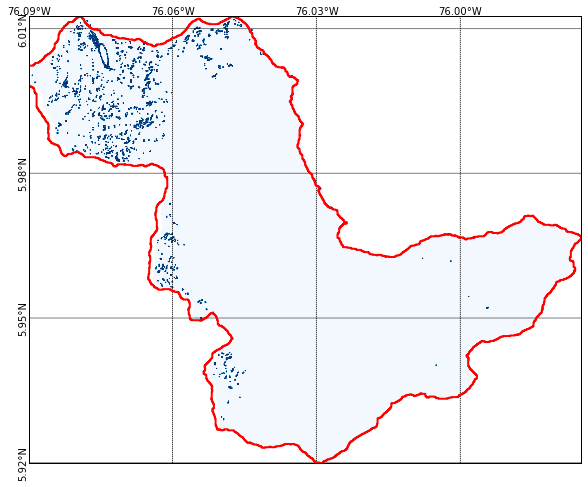

In [282]:
cu.Plot_basin(Res['Slides_Map'], colorTable=pl.get_cmap('Blues'), colorbar=False, lines_spaces=0.03)

## Lectura de mapa de deslizamientos observado

In [42]:
#Desliz, prop = wmf.read_map_raster('/media/nicolas/discoGrande/03_SALGAR/raster/observed_desliz_grande.tif')
Desliz, prop = wmf.read_map_raster('/media/nicolas/Home/nicolas/03_SALGAR/raster/observed_desliz_grande.tif')
Desliz = cu.Transform_Map2Basin(Desliz,prop)
Desliz[Desliz<>1] = 0

In [43]:
Desliz[Desliz == cu.nodata] = 0

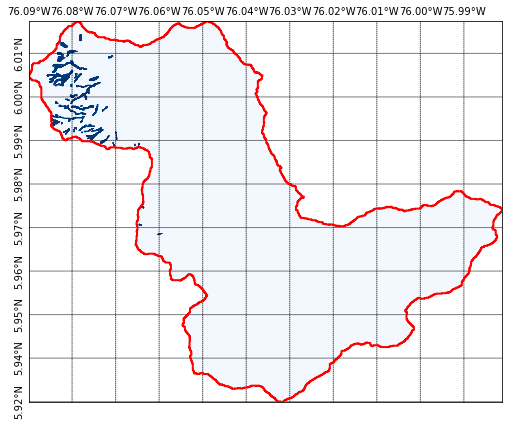

(<mpl_toolkits.basemap.Basemap at 0x7f75b6c2be10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f75b6d50dd0>)

In [44]:
cu.Plot_basin(Desliz, colorTable=pl.get_cmap('Blues'), colorbar=False)

In [37]:
Sim_Slides = Res['Slides_Map']

Se hace una funcion para determinar cuanso hay:

- verdadero positivo: simulación y observado deslizan.
- falso positivo: simulación desliza, observado no.
- falso negativo: simulación no desliza, observado si.
- acierto en no deslizamiento: simulado y observado no deslizan.

In [82]:
# Funcion para determinar 
def Slides_Aciertos(SimSlides,ObsSlides):
    pos1 = np.where((SimSlides <> 0) & (ObsSlides <> 0))[1]
    pos2 = np.where((SimSlides <> 0) & (ObsSlides == 0))[1]
    pos3 = np.where((SimSlides == 0) & (ObsSlides <> 0))[1]
    pos4 = np.where((SimSlides == 0) & (ObsSlides == 0))[1]
    Aciertos = np.zeros(SimSlides.size)
    Aciertos[pos1] = 1
    Aciertos[pos2] = 2
    Aciertos[pos3] = 3
    return Aciertos

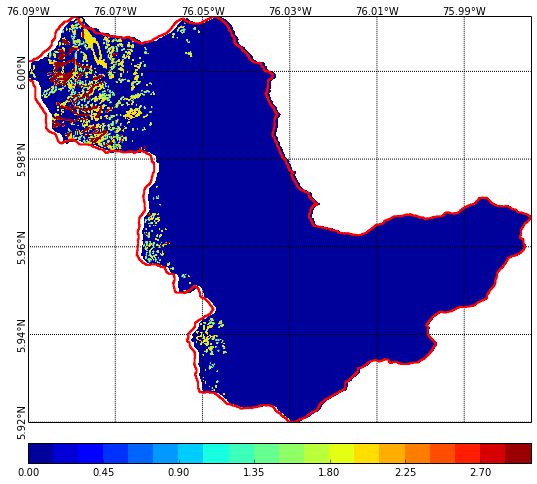

(176,)
(3750,)
(2603,)


In [91]:
Ac = Slides_Aciertos(Sim_Slides,Desliz)
cu.Plot_basin(Ac)
print Ac[Ac == 1].shape
print Ac[Ac == 2].shape
print Ac[Ac == 3].shape

## Por hacer

- Distribucion de los parametro de suelo en función del IT.
- y en función de la pendiente.
- Comparar con la catena.
- Animaciones
- Comprar con resultados presentados por Montgomery y Ditrich

___
### 1. Distribución en función de IT

El índice topográfico se define mediante la siguiente expresión:

$IT = \frac{a}{tan b}$

Done:

- $a$: area unitaria acumulada en este caso **cu.CellAcum**.
- $b$: Pendiente en radianes, en este caso **wmf.models.sl_radslope**.

In [23]:
ITbasin = cu.GetGeo_IT()

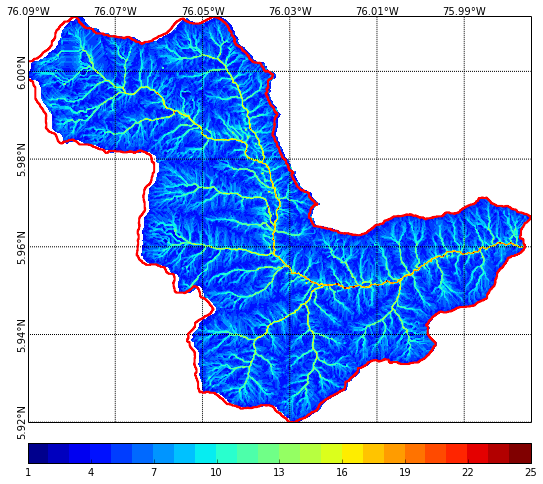

In [24]:
cu.Plot_basin(ITbasin)

Se comparan los histogramas de la ocurrencia de deslizamientos observados y simulados, los histogramas son los obtenidos para la variable de índice topográfico:

Vamos a tratar de encontrar alguna relación entre la conductividad hidráulica saturada y el índice topográfico

In [25]:
ks = np.copy(wmf.models.v_coef[1])
ksh = np.copy(wmf.models.h_coef[1])

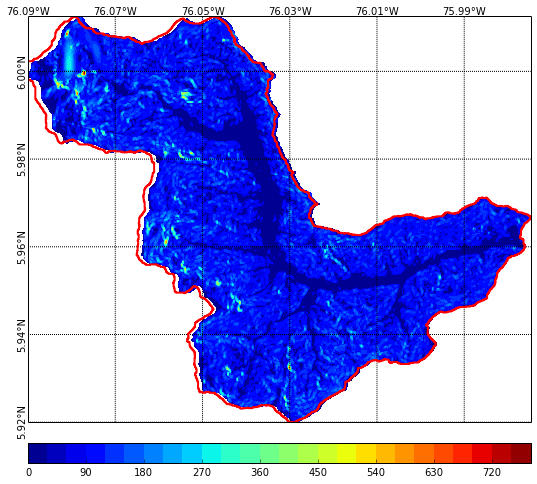

In [26]:
cu.Plot_basin(wmf.models.h_coef[1])

In [42]:
p = np.random.choice(cu.ncells, 1000)

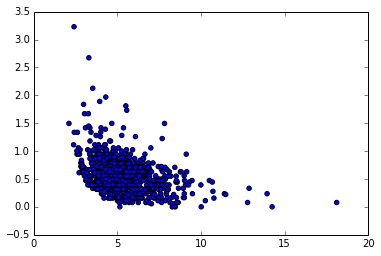

In [46]:
pl.scatter(ITbasin[p], cu.CellSlope[p])

In [61]:
Hg = np.copy(wmf.models.max_gravita[0])

### Ensayo de sensibilidad al incluir IT dentro de la estimación de Ks (IT afecta de forma inversa)

Ensayos de modificaciones de ks en función de IT, pensando que este varía de forma negativa en la medida en que IT se hace mayor (zonas de alta convergencia de humedad y bajo transporte)

In [295]:
KsMedio = []
KshMedio = []
Nslides = []
MapasDesliz = {}
for i in range(1,12,1):
    #Calcula el ks y el ksh de kubota en funcion del IT
    ks = 0.00126 * (1.0/ITbasin/i)
    KsMedio.append(ks.mean())
    ksh = (ks*cu.CellSlope*(12.7**2.0))/(3*(Hg*0.9/1000.0)**2)
    KshMedio.append(ksh.mean())
    #Ejecuta el modelo de deslizamientos en ese periodo
    cu.set_PhysicVariables('h_coef',ksh, 1)
    Res = cu.run_shia(Calibracion,ruta_lluvia+'.bin',Npasos,Inicio)
    Nslides.append(Res['Slides_NCell_Serie'])
    #Guarda el mapa objectsevado 
    MapasDesliz.update({str(i):Res['Slides_Map']})

In [293]:
ks = 0.00126 * (1.0/ITbasin)
ksh = (ks*cu.CellSlope*(12.7**2.0))/(3*(Hg*0.9/1000.0)**2)

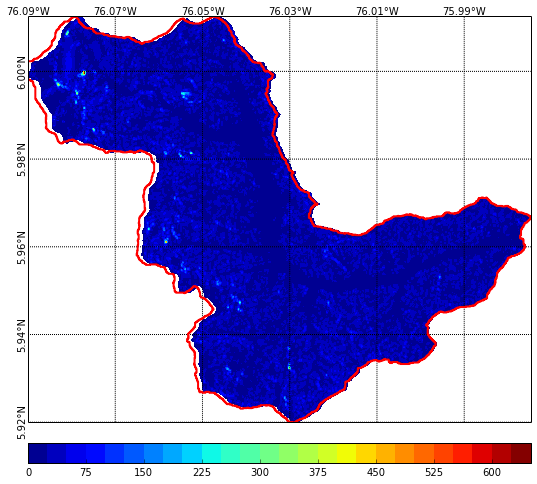

In [294]:
cu.Plot_basin(ksh)

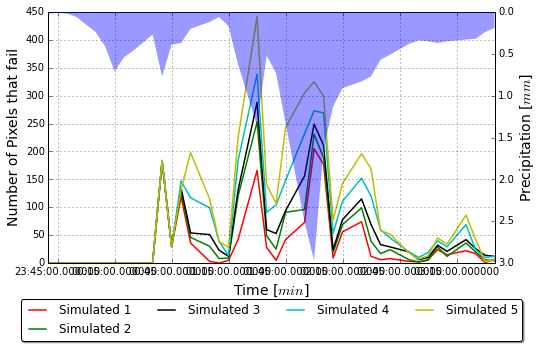

In [181]:
wmf.plot_sim_single(np.array(Nslides), mrain=S.values, Dates = S.index.to_pydatetime(), 
    ylabel = 'Number of Pixels that fail')

In [184]:
DictDesempeno = {}
for i in range(1,12):
    Ac = Slides_Aciertos(MapasDesliz[str(i)],Desliz)
    DictDesempeno.update({str(i):
        {'acierto': Ac[Ac == 1].shape[0],
        'falso_pos':Ac[Ac == 2].shape[0],
        'falso_neg':Ac[Ac == 3].shape[0],
        'acierto_no':Ac[Ac == 0].shape[0]}})

In [237]:
cu.ncells

352540

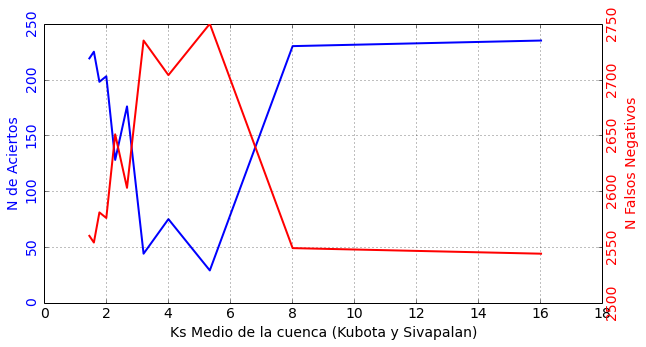

In [191]:
Aciertos = []
FalsoNeg = []
for k in DictDesempeno.keys():
    Aciertos.append(DictDesempeno[k]['acierto'])
    FalsoNeg.append(DictDesempeno[k]['falso_neg'])
#Figura de desempeno
fig = pl.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
#Pinta aciertos
ax1.plot(KshMedio,Aciertos, lw = 2)
ax1.set_xlabel('Ks Medio de la cuenca (Kubota y Sivapalan)', size = 14)
ax1.set_ylabel('N de Aciertos', size = 14, color = 'b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
    tl.set_fontsize(14)
    tl.set_rotation(90)
for tl in ax1.get_xticklabels():
    tl.set_fontsize(14)
#Pinta falsos negativos
ax2 = ax1.twinx()
ax2.plot(KshMedio, FalsoNeg, 'r', lw = 2)
ax2.set_ylabel('N Falsos Negativos', size = 14,color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
    tl.set_fontsize(14)
    tl.set_rotation(90)
ax1.grid(True)

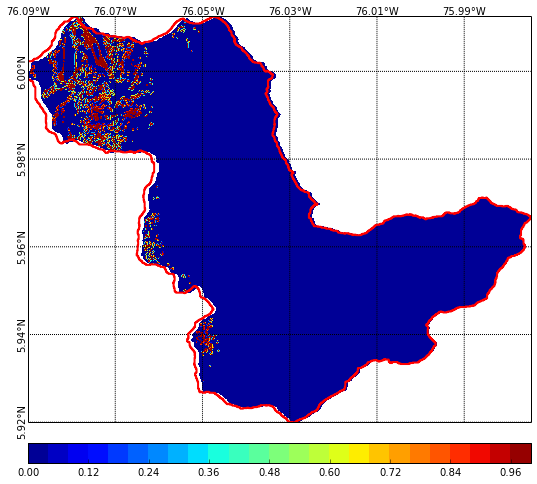

### Ensayo de sensibilidad al incluir IT dentro de la estimación de Ks (IT afecta de forma directa)

Ensayos de modificaciones de ks en función de IT, pensando que este varía de forma negativa en la medida en que IT se hace mayor (zonas de alta convergencia de humedad y bajo transporte)

In [287]:
KsMedio = []
KshMedio = []
Nslides = []
MapasDesliz = {}
for i in range(1,12,1):
    #Calcula el ks y el ksh de kubota en funcion del IT
    ks = 0.00126 * (ITbasin/i)
    KsMedio.append(ks.mean())
    ksh = (ks*cu.CellSlope*(12.7**2.0))/(3*(Hg*0.9/1000.0)**2)
    KshMedio.append(ksh.mean())
    #Ejecuta el modelo de deslizamientos en ese periodo
    cu.set_PhysicVariables('h_coef',ksh, 1)
    Res = cu.run_shia(Calibracion,ruta_lluvia+'.bin',Npasos,Inicio)
    Nslides.append(Res['Slides_NCell_Serie'])
    #Guarda el mapa obsevado 
    MapasDesliz.update({str(i):Res['Slides_Map']})

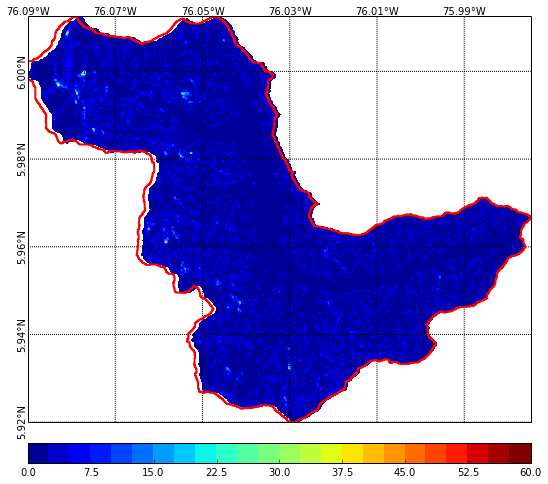

In [298]:
cu.Plot_basin(ksh)

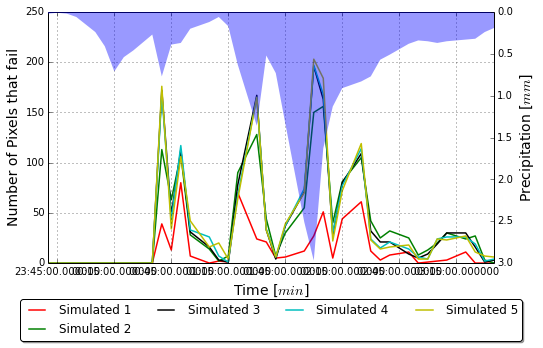

In [194]:
wmf.plot_sim_single(np.array(Nslides), mrain=S.values, Dates = S.index.to_pydatetime(), 
    ylabel = 'Number of Pixels that fail')

In [195]:
DictDesempeno = {}
for i in range(1,12):
    Ac = Slides_Aciertos(MapasDesliz[str(i)],Desliz)
    DictDesempeno.update({str(i):
        {'acierto': Ac[Ac == 1].shape[0],
        'falso_pos':Ac[Ac == 2].shape[0],
        'falso_neg':Ac[Ac == 3].shape[0]}})

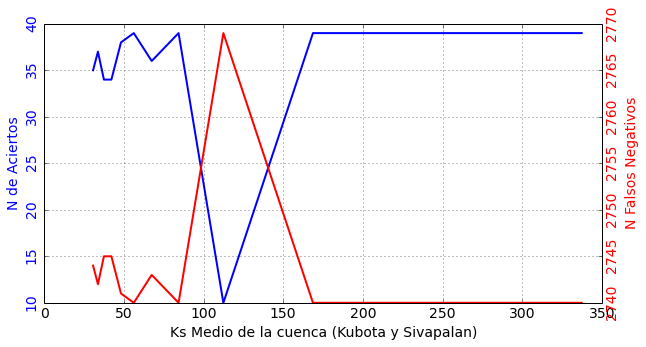

In [196]:
Aciertos = []
FalsoNeg = []
for k in DictDesempeno.keys():
    Aciertos.append(DictDesempeno[k]['acierto'])
    FalsoNeg.append(DictDesempeno[k]['falso_neg'])
#Figura de desempeno
fig = pl.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
#Pinta aciertos
ax1.plot(KshMedio,Aciertos, lw = 2)
ax1.set_xlabel('Ks Medio de la cuenca (Kubota y Sivapalan)', size = 14)
ax1.set_ylabel('N de Aciertos', size = 14, color = 'b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
    tl.set_fontsize(14)
    tl.set_rotation(90)
for tl in ax1.get_xticklabels():
    tl.set_fontsize(14)
#Pinta falsos negativos
ax2 = ax1.twinx()
ax2.plot(KshMedio, FalsoNeg, 'r', lw = 2)
ax2.set_ylabel('N Falsos Negativos', size = 14,color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
    tl.set_fontsize(14)
    tl.set_rotation(90)
ax1.grid(True)

## Inundaciones 

Preparación del modelo de inundaciones 

In [86]:
cu.set_Floods(1000, 'GammaWater')
cu.set_Floods(2600, 'GammaSoil')
cu.set_Floods(1/180.0, 'VelArea')
cu.set_Floods(0.75, 'Cmax')

#Ancho
cu.GetQ_Balance(2000)
W = 3.26 * cu.CellQmed ** 0.469
#cu.Plot_basin(W, colorTable=pl.get_cmap('viridis'), colorbarLabel=u'Ancho de la sección Estimado $[mts]$')
cu.set_Floods(W, 'Stream_W')
#Pendiente
cu.set_Floods(0,'Slope')
#D50 
cu.set_Floods(0.138, 'Stream_D50')
#Tamano de celda
wmf.models.dxp = 12.7

In [85]:
#secciones 
cu.set_Floods(0,'Sections', NumCeldas=4)

In [30]:
wmf.models.sim_floods = 1
wmf.models.flood_umbral = 1.5
wmf.models.flood_max_iter = 4
wmf.models.flood_step = 0.2
Inicio = 220

In [88]:
wmf.models.save_speed = 0
wmf.models.save_storage = 0

Cargado de condiciones iniciales antes de simulación 

In [31]:
v,r = wmf.models.read_float_basin_ncol('Storage_maps2.StObin',Inicio,cu.ncells,5)
for c,i in enumerate(v):
    cu.set_Storage(i,c)

Ejecución del modelo 

In [47]:
#Cantidad de pasos
Npasos = 60
Inicio = 220
#Ejecucion
ruta_lluvia = '/media/nicolas/discoGrande/03_SALGAR/bin_rain/Mayo_18_19_12mts'
Calibracion = [0.05, 5, 0.8, 0.0, 1.0, 1.5, 1, 0.996, 2.0, 1.0]
Res = cu.run_shia(Calibracion,ruta_lluvia+'.bin',Npasos, Inicio +1, kinematicN=6)
Rain = wmf.read_mean_rain(ruta_lluvia+'.hdr',Npasos,Inicio)

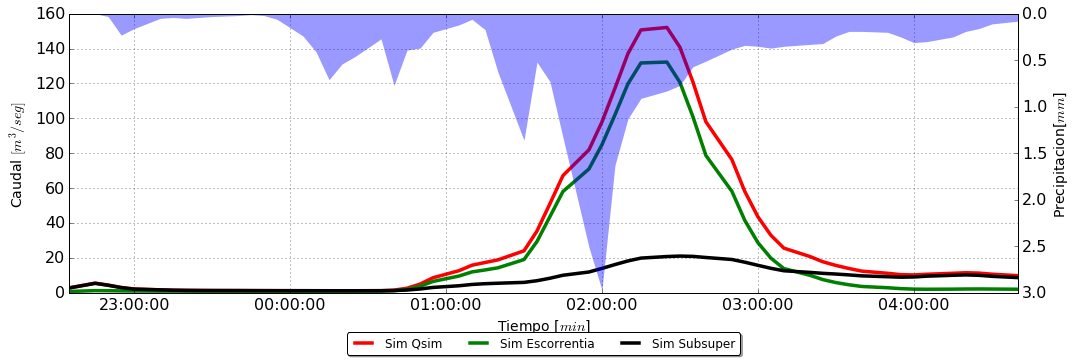

In [48]:
Qsim = Res['Qsim'][0]
Base = Qsim - Res['Fluxes'][0][0] - Res['Fluxes'][0][1]
Runoff = Res['Fluxes'][0][0] + Base
SubSuper = Res['Fluxes'][0][1] + Base

plot_sim_single(np.vstack([Qsim, Runoff, SubSuper]), 
    ids=['Qsim','Escorrentia', 'Subsuper'], Dates = Rain.index.to_pydatetime(),
    mrain = Rain.values,
    #ruta = 'Figuras-6-Enero-2016/Simulaciones/Sim_Qsim_Res.png',
    figsize=(17,5),)

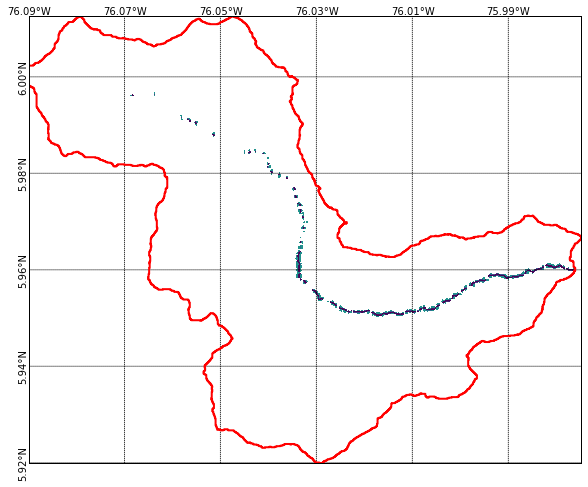

In [89]:
flood = np.copy(wmf.models.flood_flood)
flood[(flood<>1) & (flood<>2)] = 0
cu.Plot_basin(flood, colorbar=False, colorTable=pl.get_cmap('viridis_r'), ZeroAsNaN='si')

In [23]:
m = cu.Transform_Basin2Map(flood, '/media/nicolas/discoGrande/03_SALGAR/raster/inundacion3.tif')

### Animación Mancha de Inundación

In [ ]:
Npasos = 60
Inicio = 220
#Ejecucion
for i in range(60):
    #Numeracion de la imagen
    if i<10:
        nameText = '0' + str(i)
    else:
        nameText = str(i)
    #ejecucion    
    Res = cu.run_shia(Calibracion,ruta_lluvia+'.bin',1, 221+i, kinematicN=10)
    for c,j in enumerate(Res['Storage']):
        cu.set_Storage(j,c)
    flood = np.copy(wmf.models.flood_flood)
    flood[(flood<>1) & (flood<>2)] = 0
    cu.Plot_basin(flood, colorbar=False, colorTable=pl.get_cmap('viridis'), 
        ruta='Animacion/EjemploMancha/Mancha'+nameText+'.png')

### Animación de la evolución de la hidrógrafa

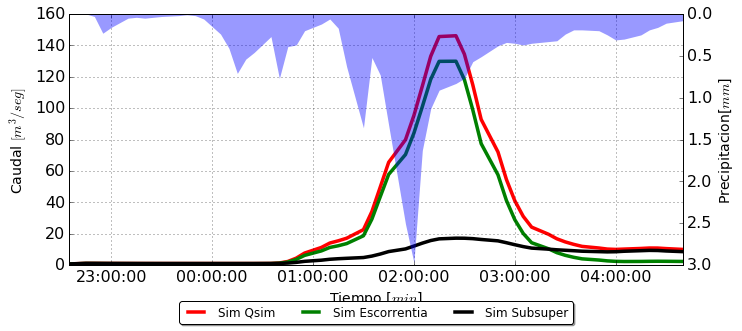

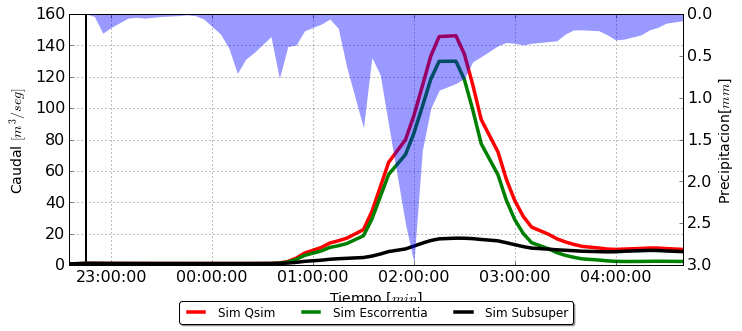

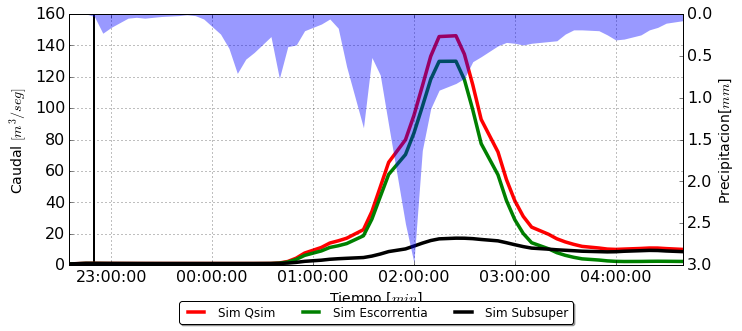

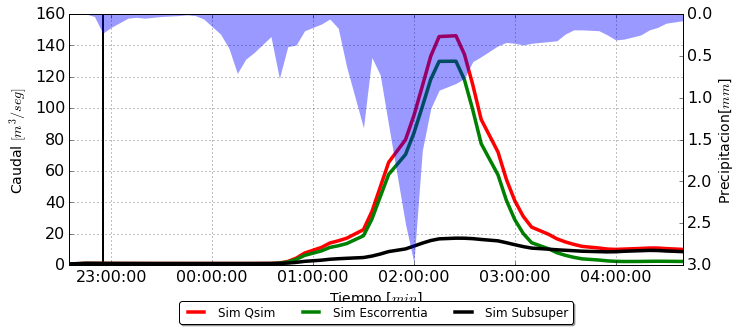

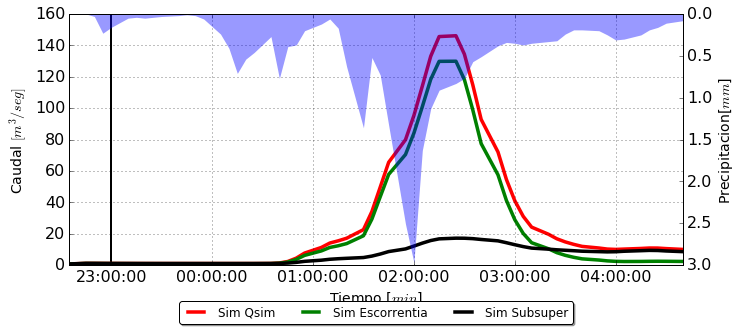

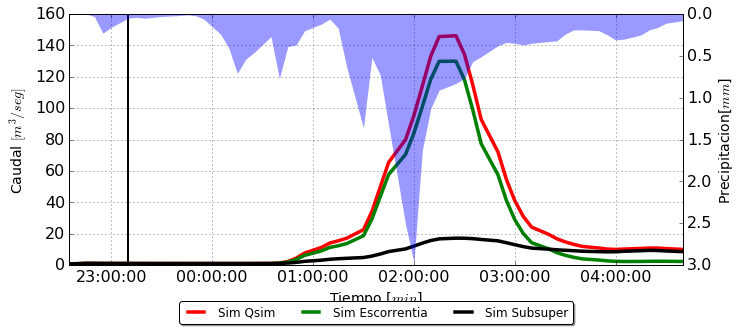

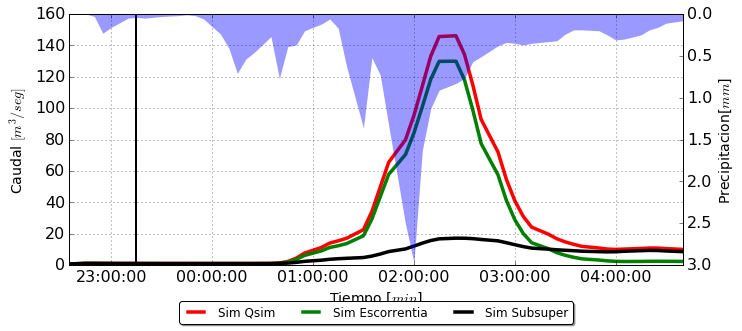

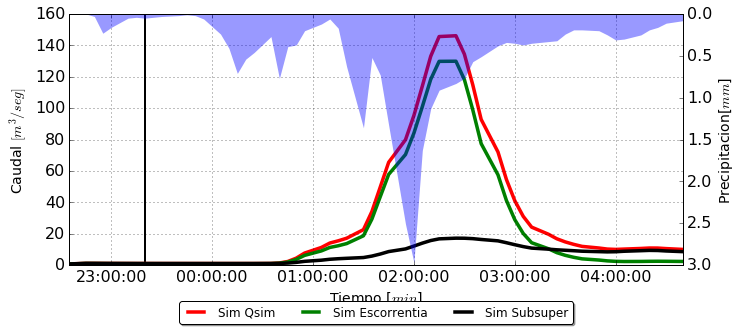

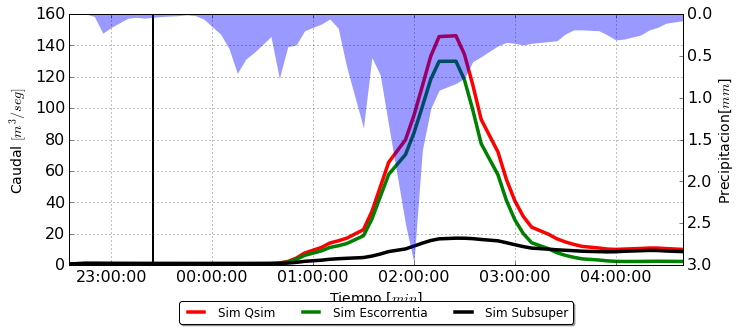

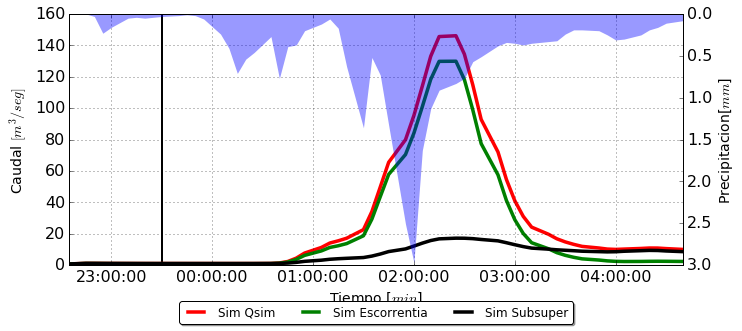

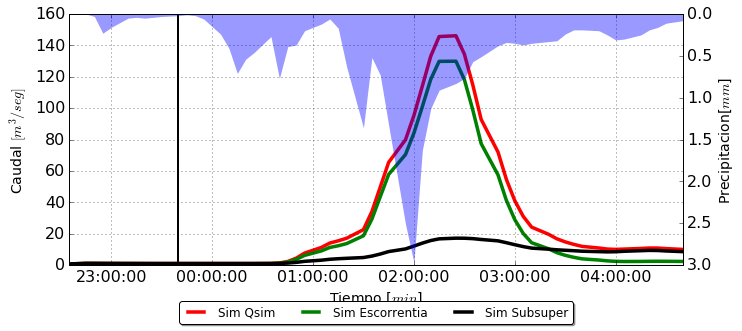

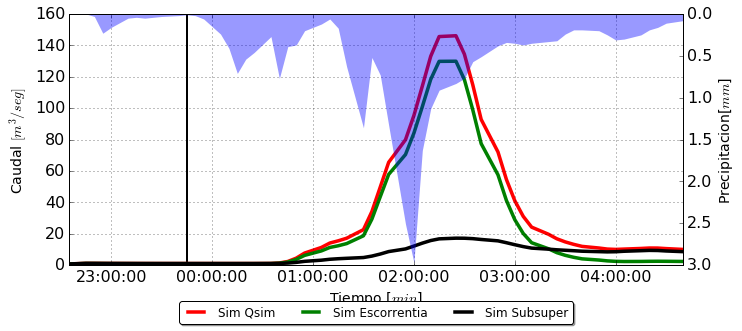

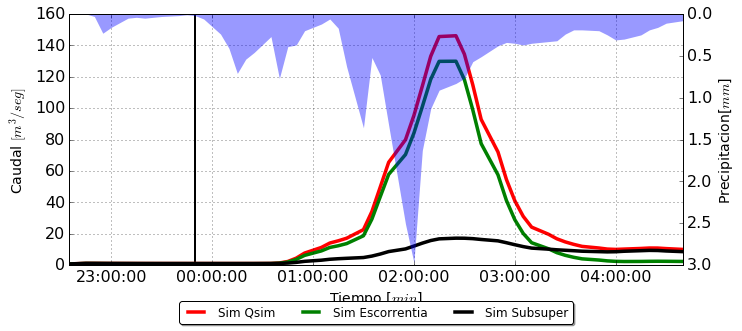

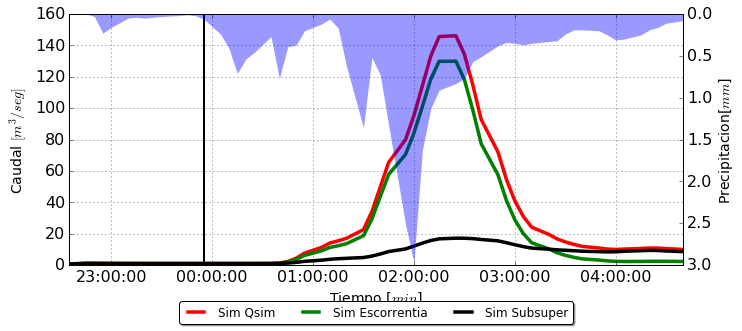

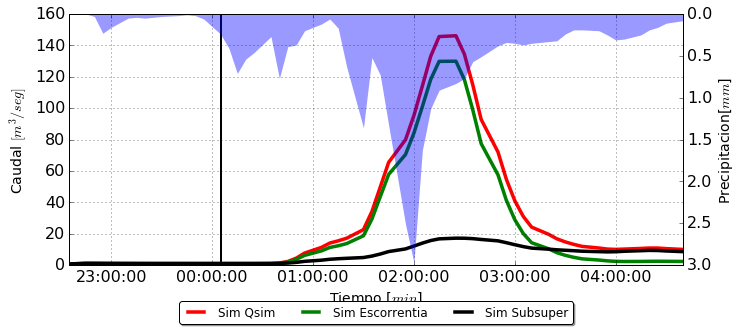

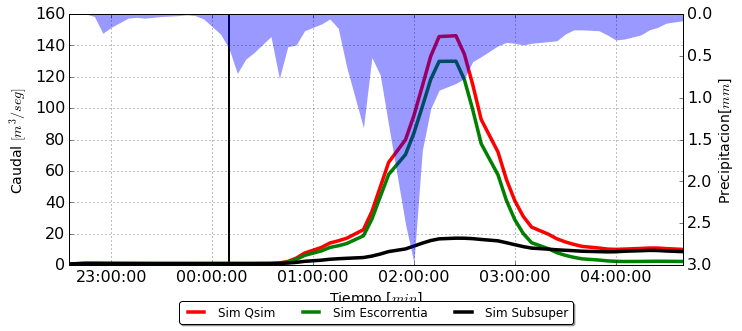

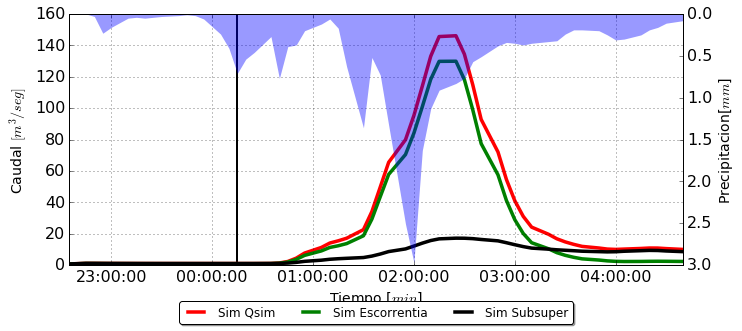

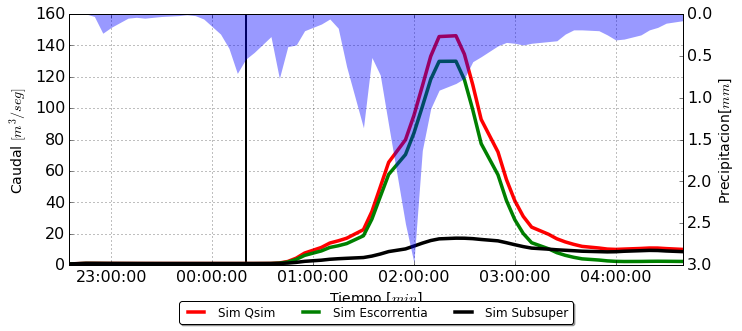

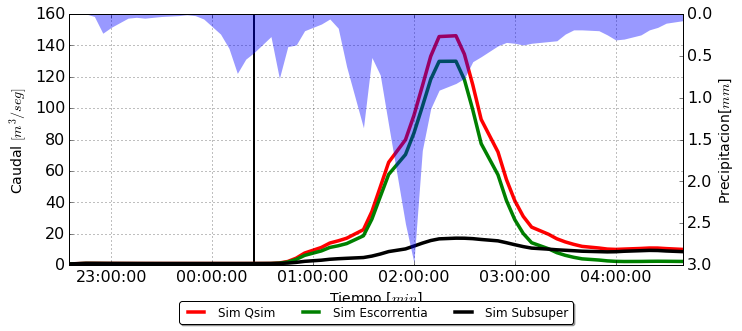

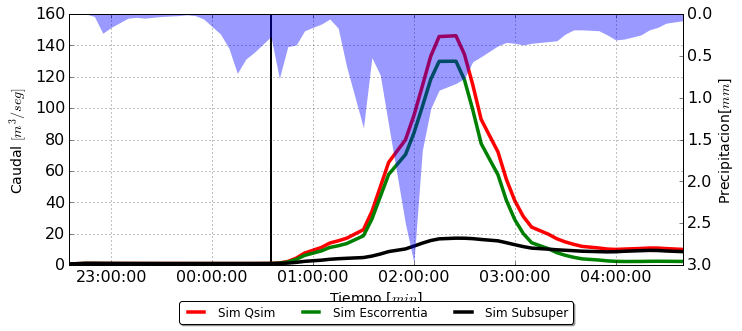

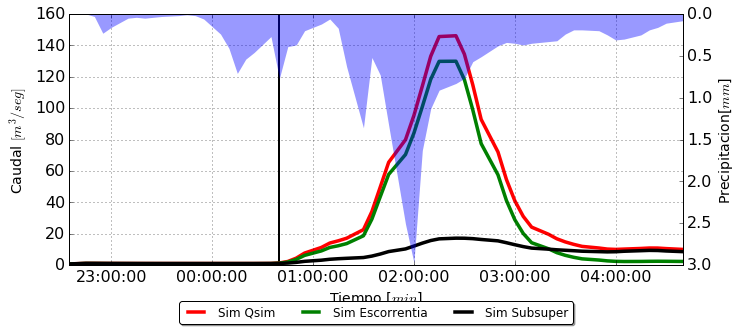

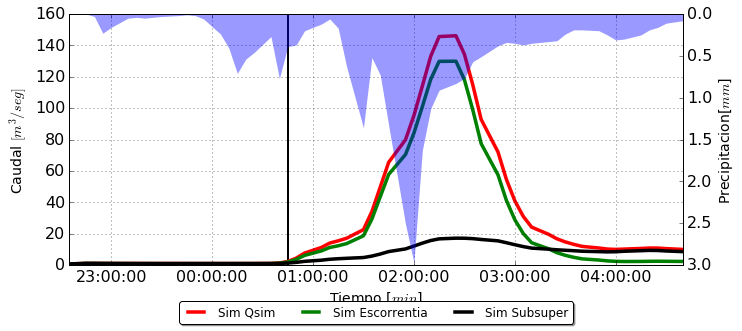

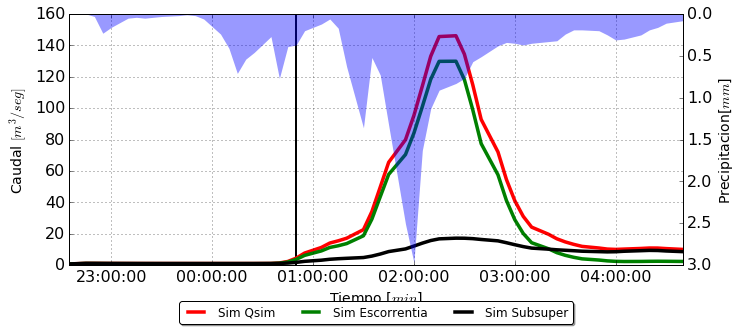

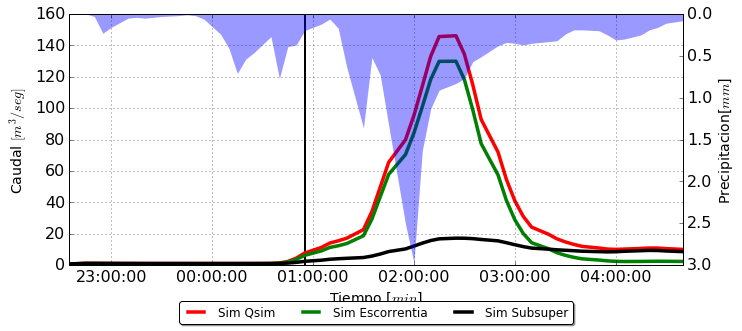

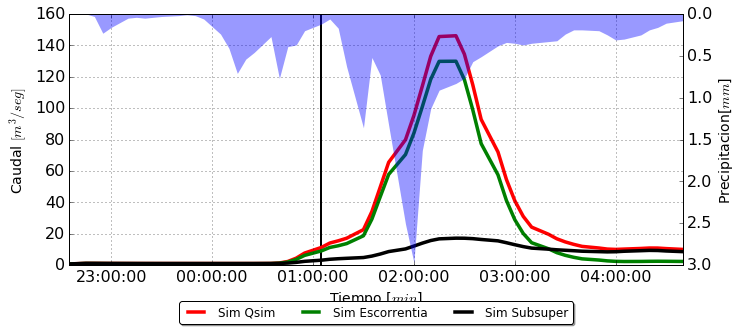

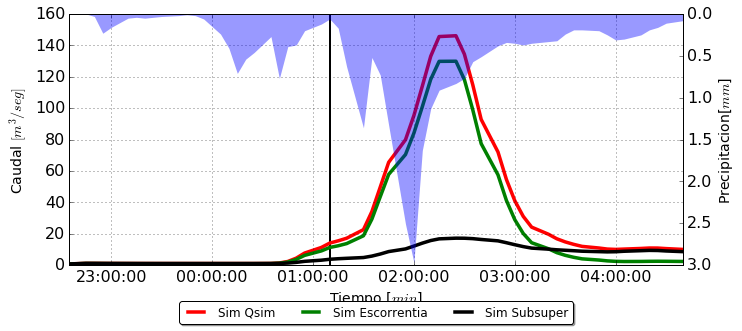

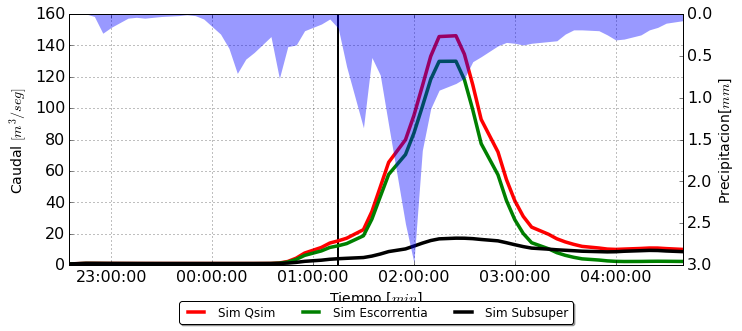

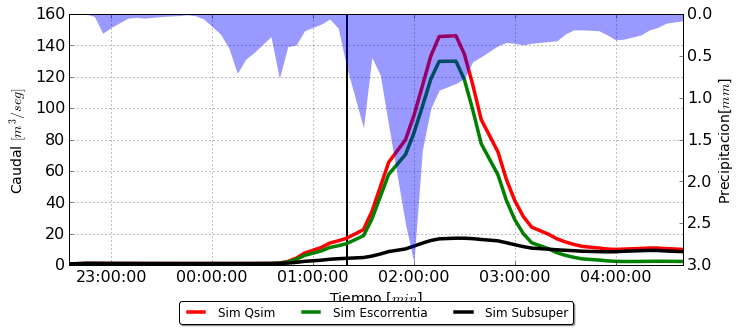

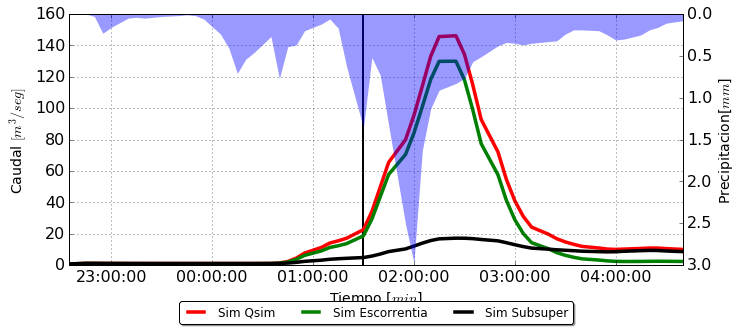

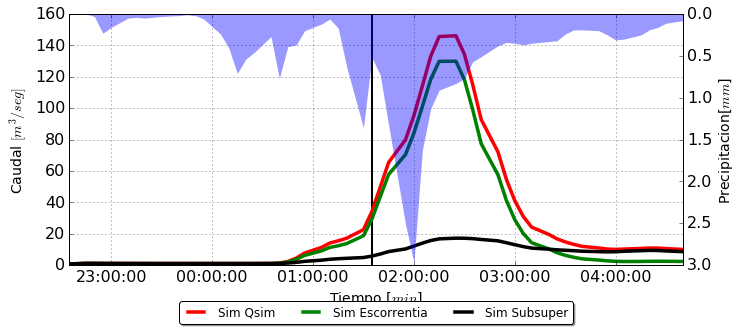

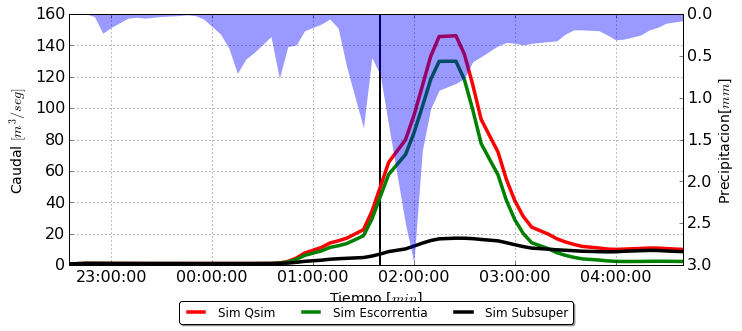

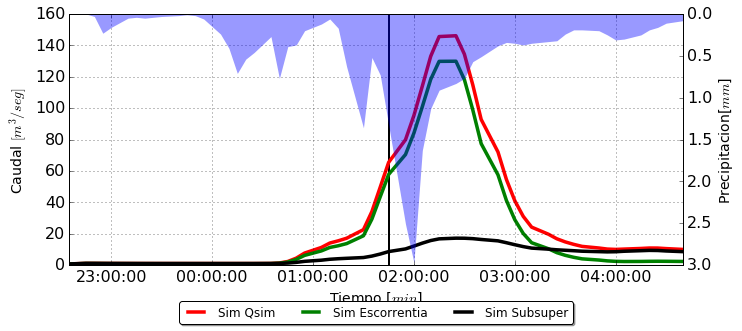

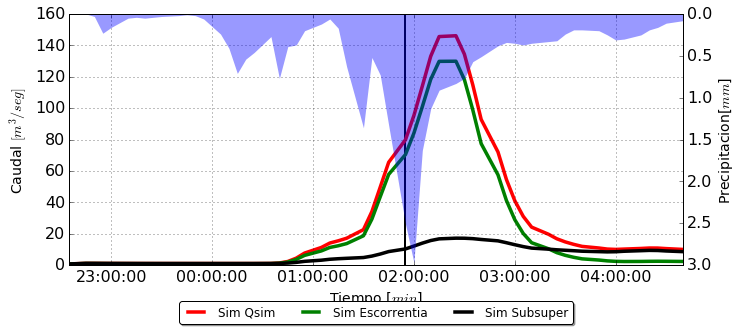

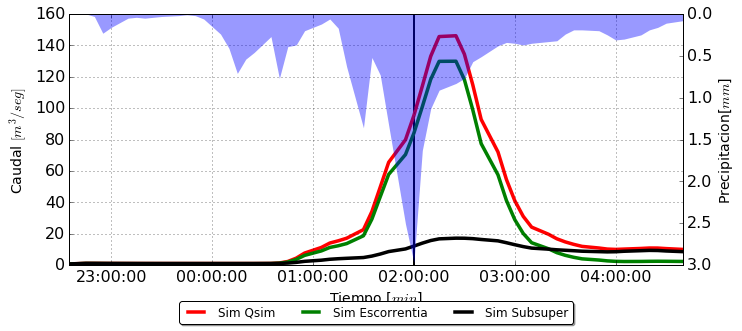

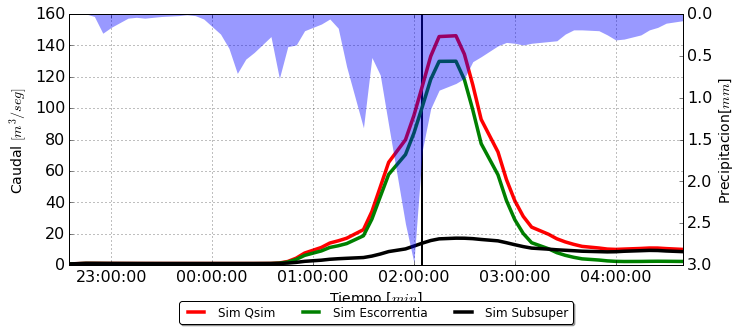

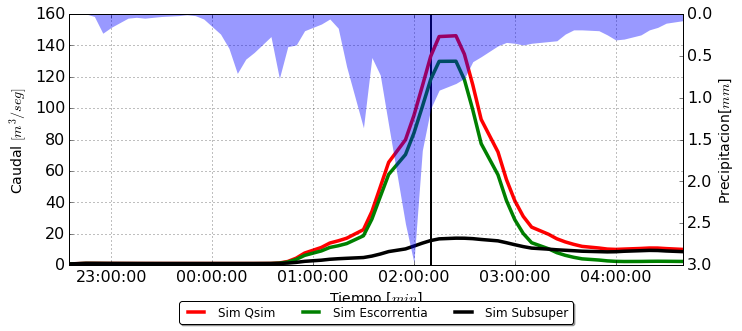

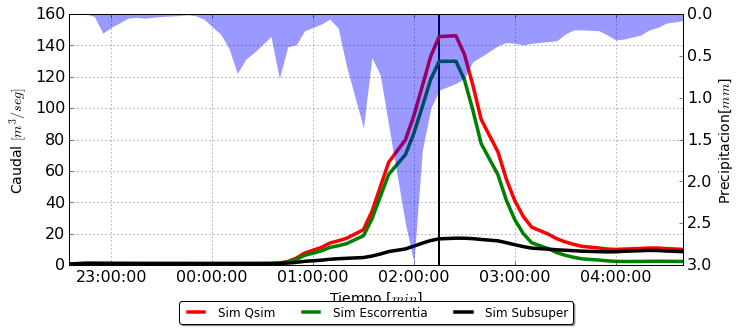

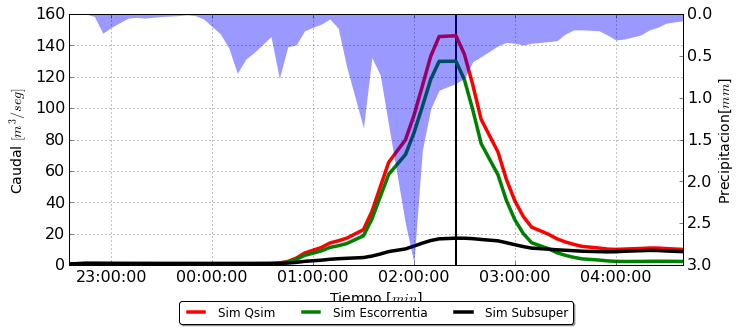

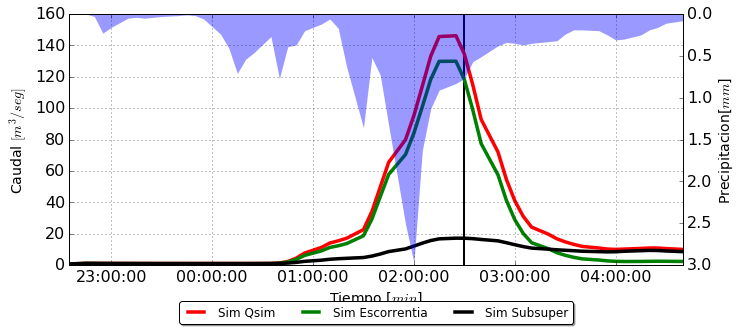

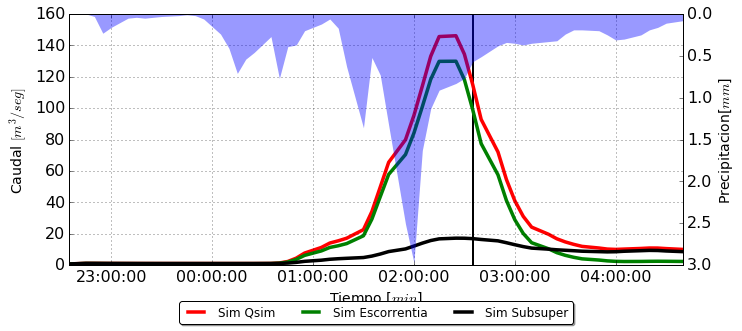

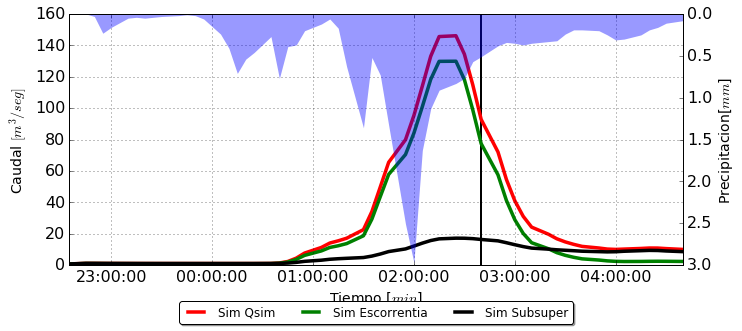

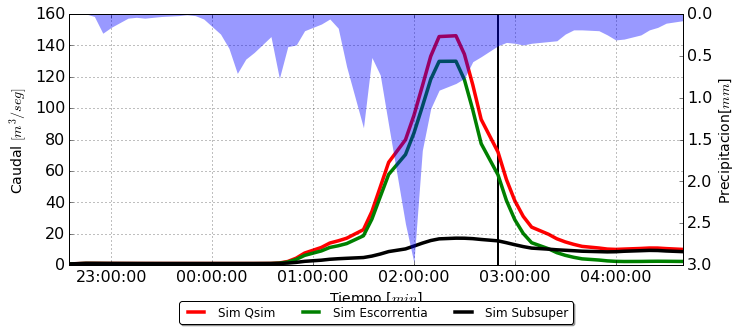

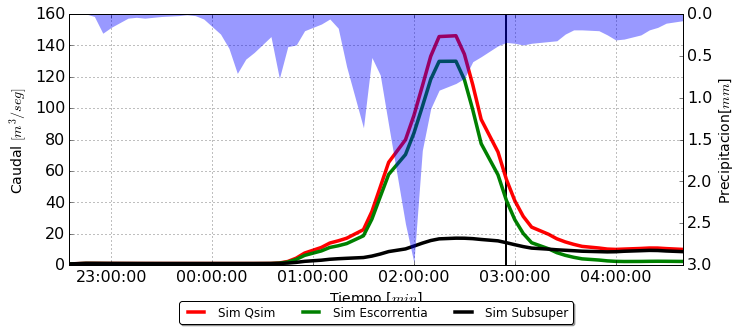

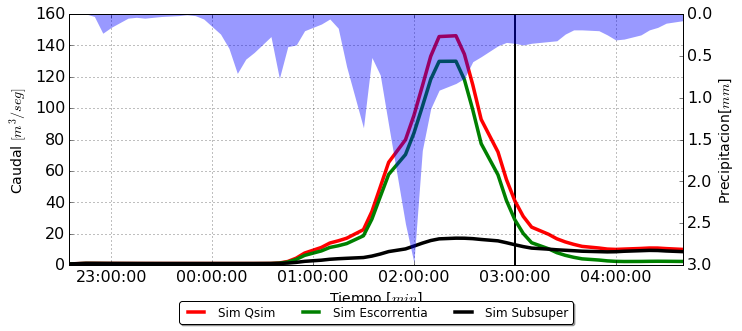

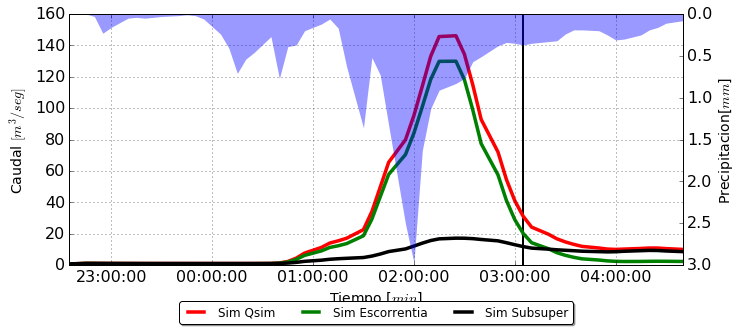

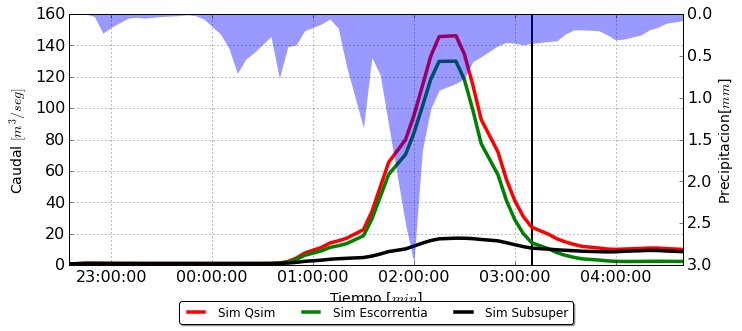

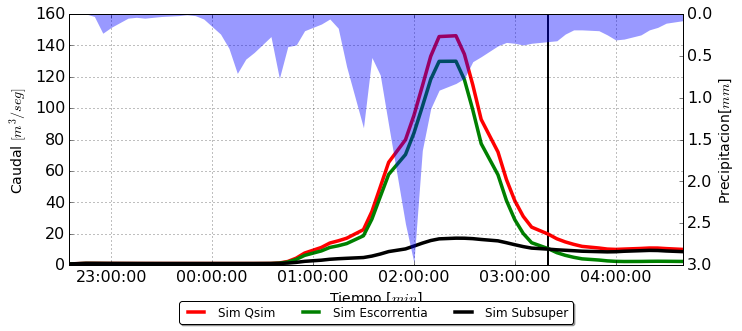

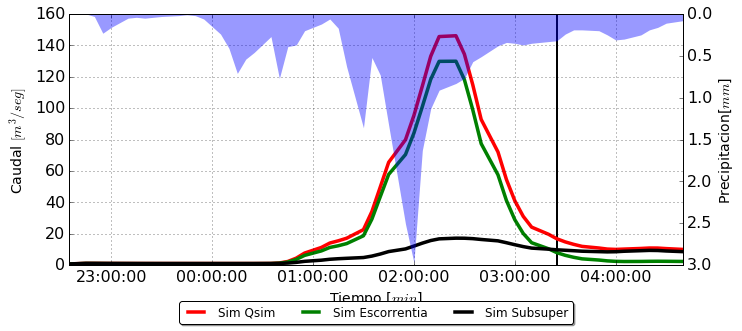

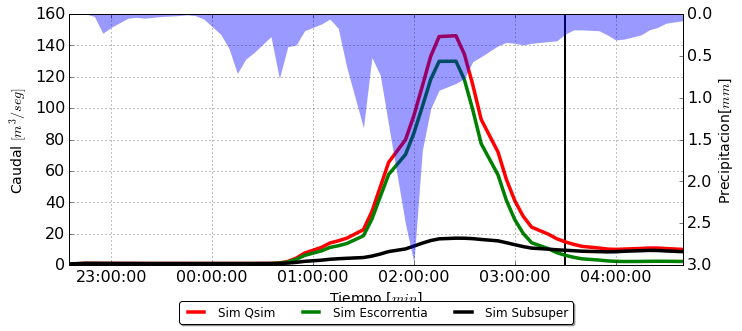

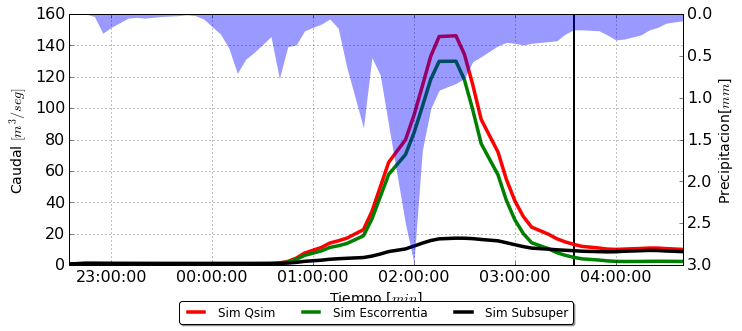

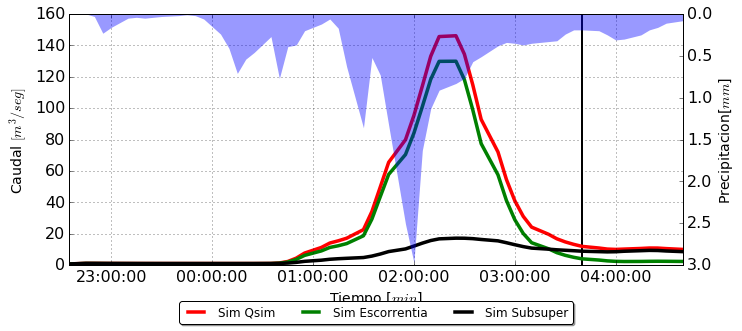

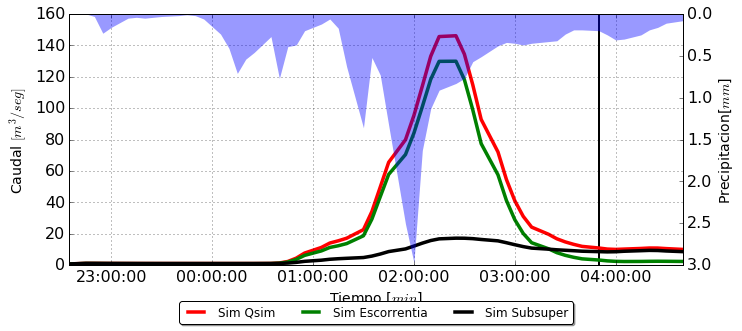

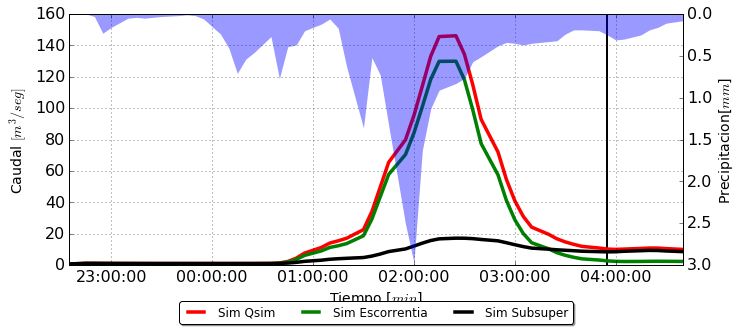

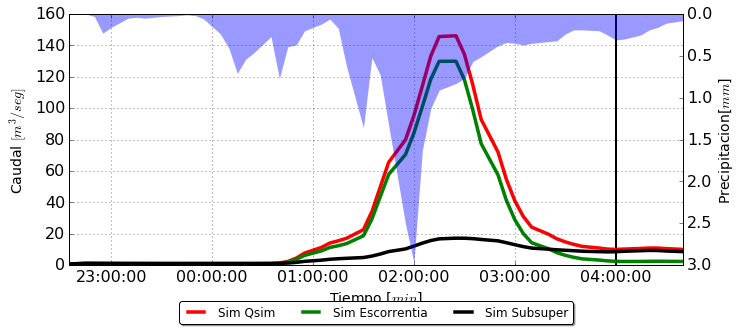

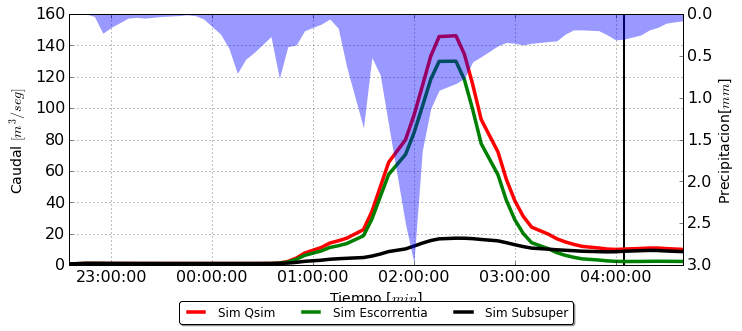

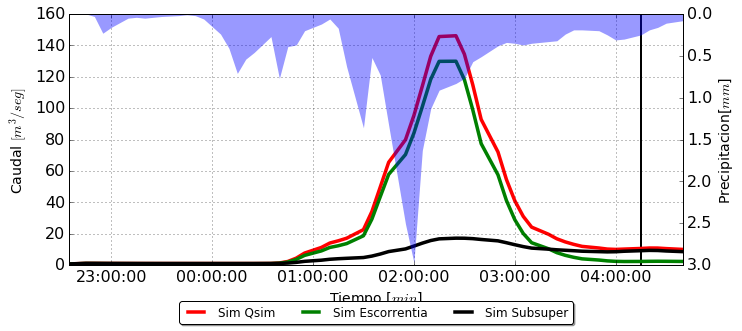

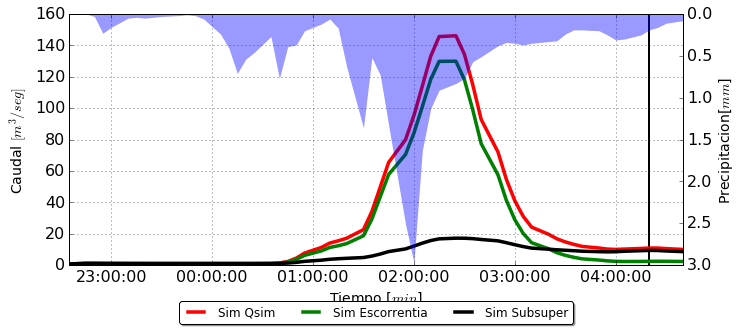

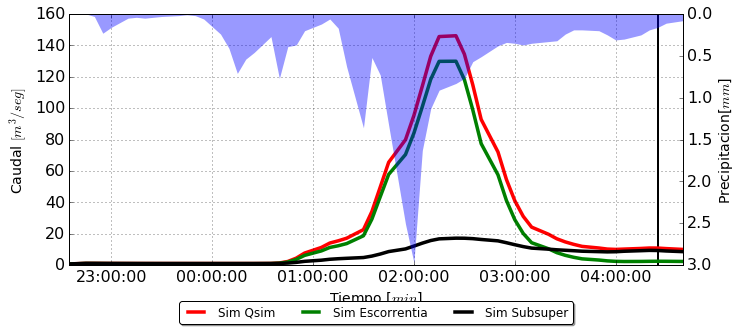

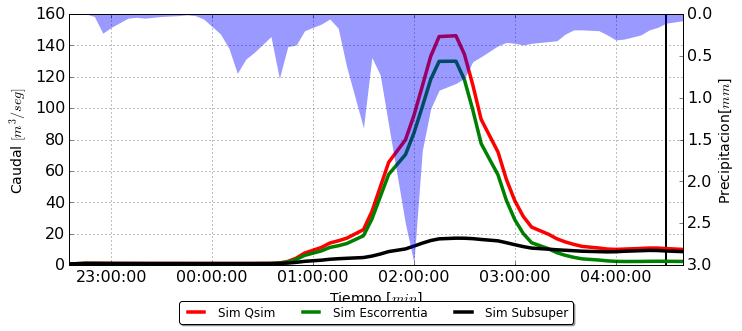

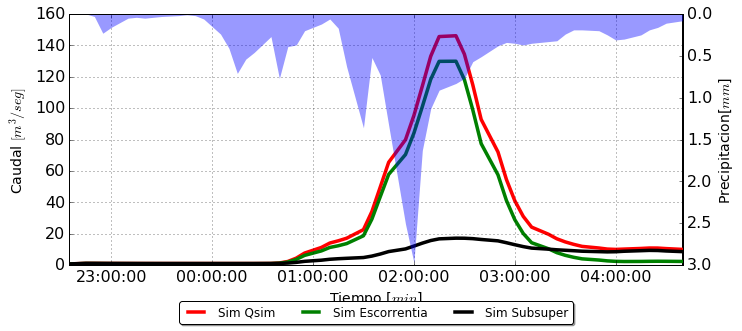

In [96]:
Nintervals = Npasos
for c,i in enumerate(range(Nintervals)):
    #Cambia a nameTetx
    if c<10:
        nameText = '00'+str(c)
    elif c<100:
        nameText = '0'+str(c)
    else:
        nameText = str(c)
    #HAce el plot de la simulacion 
    plot_sim_single(np.vstack([Qsim, Runoff, SubSuper]), 
        ids=['Qsim','Escorrentia','Subsuper'], Dates = Rain.index.to_pydatetime(),
        mrain = Rain.values,
        ruta = 'Animacion/EjemploMancha/Evol_Hidro_'+nameText+'.png',
        figsize=(11,4.5),
        vline = Rain.index.to_pydatetime()[c])

### Animación Inundación en una sección 

In [24]:
cu.GetGeo_Sections(NumCeldas=10)

In [25]:
sec = np.copy(cu.Sections.T)
possec = []
for c,i in enumerate(sec):
    if np.count_nonzero(i)>0:
        possec.append(c)

In [80]:
def Plot_seccion(seccion, linea, pos, ruta = None):
    #Obtiene param de la seccion 
    fondo = seccion[(seccion.shape[0]/2)+1]
    #Figura
    fig = pl.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.plot(seccion, c = '#54641D', lw = 3)
    ax.plot(linea, c = 'k', lw =1.5)
    ax.fill_between(pos, seccion[pos], linea[pos])
    ax.fill_between(range(21), fondo - 2, seccion, color = '#92B223')
    ax.grid(True)
    ax.set_ylim(fondo - 2, seccion.max()+2)
    ax.tick_params(labelsize = 14)
    ax.set_ylabel('Elevacion $[m.s.n.m]$', size = 16)
    ax.set_xlabel('Distancia del cauce', size = 16)
    a = ax.set_xticks(range(21))
    a = ax.set_xticklabels(np.arange(-10,11))
    #Guardado 
    if ruta<>None:
        pl.savefig(ruta, bbox_inches = 'tight')
    pl.plot()

In [ ]:
fondo = sec[possec[-2]][10]
paso = 0.5

for i in range(25):
    #Nombre
    if i<10:
        nameText = '0'+str(i)
    else:
        nameText = str(i)
    #Diferencias
    linea = np.ones(21)*fondo + paso*i
    dif = linea - sec[possec[-2]] 
    pos = np.where(dif>0)[0]
    #Plot bonito 
    Plot_seccion(sec[possec[-2]], linea, pos,
        ruta = 'Animacion/EjemploMancha/Paso_'+nameText+'.png')
